#### Paper figures <a id='top'></a>

- [Figure 1](#figure1)
- [Figure 2](#figure2)
- [Figure 3](#figure3)
- [Figure 4](#figure4)
- [Figure 5](#figure5)

In [1]:
import memo_py as me
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import scipy.stats as stats
from scipy import integrate
import pymc3
%matplotlib inline

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


##### Color palette

<img src="color_pal.png" width="500">

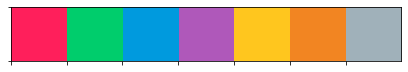

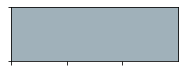

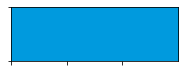

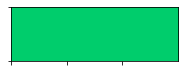

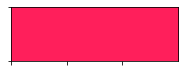

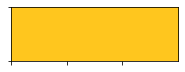

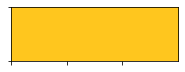

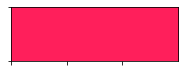

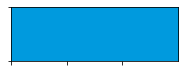

In [2]:
# https://www.molecularecologist.com/2020/04/simple-tools-for-mastering-color-in-scientific-figures/
geodataviz = sns.color_palette(["#FF1F5B", "#00CD6C", "#009ADE", "#AF58BA", "#FFC61E", "#F28522", "#A0B1BA"])
sns.palplot(geodataviz)

# sns.palplot(sns.color_palette("Set2"))
# sns.palplot(sns.color_palette("viridis"))

# define colors
grey = geodataviz[-1]; sns.palplot(grey)
cnaive = geodataviz[2]; sns.palplot(cnaive)
cactiv = geodataviz[1]; sns.palplot(cactiv)
cwact = geodataviz[0]; sns.palplot(cwact) # 2, 3
cwdiv = geodataviz[4]; sns.palplot(cwdiv)
ctopx = geodataviz[4]; sns.palplot(ctopx)
ctopy = geodataviz[0]; sns.palplot(ctopy)
ctopz = geodataviz[2]; sns.palplot(ctopz)

##### Figure settings

In [3]:
# plt.rcParams.update({'figure.autolayout': True})
# plt.rcParams.update({'figure.figsize': (1.5, 1)}) # can be adapted for each plot
# plt.rcParams.update({'figure.figsize': (8, 5)})
plt.rcParams.update({'font.size': 6})
plt.rcParams['font.family'] = 'Helvetica Neue'
# plt.rcParams['font.weight'] = 'medium'

# temp disabled
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Helvetica Neue'
plt.rcParams['mathtext.it'] = 'Helvetica Neue:italic'

plt.rcParams['axes.linewidth'] = 0.3
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['ytick.minor.width'] = 0.3

plt.rcParams.update( {# 'legend.fontsize': 20,
          'legend.handlelength': 1.0/2.0})

##### Waiting time functions

In [79]:
def waiting_time_distr_samples_act(x, res, samples, time_max, mprior):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)
    
    # for checking set a counter
    model_type_counts = np.zeros((4,))
    
    # set general x values
    y = np.zeros((x.shape[0], samples))

    for i in range(samples):
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]
        
        # decide whether phase type or markov/erlang model
        # par3 model
        if 'alphaT' in est.net.net_name:
            model_type_counts[3] += 1
#             print('par3')
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # read out steps for the first half of the channels (by construction)
            alpha_F_steps = est.net.net_modules[0]['module_steps']
            alpha_S_steps = est.net.net_modules[2]['module_steps']
            alpha_T_steps = est.net.net_modules[4]['module_steps']

            # read out rates for the first half of the channels (by construction)
            alpha_F_rate = theta[0]
            alpha_S_rate = theta[1]
            alpha_T_rate = theta[2]

            # calculate channel probabilities
            alpha_total_paths = alpha_F_steps * alpha_F_rate + alpha_S_steps * alpha_S_rate + alpha_T_steps * alpha_T_rate
            alpha_F_path = (alpha_F_steps * alpha_F_rate)/alpha_total_paths
            alpha_S_path = (alpha_S_steps * alpha_S_rate)/alpha_total_paths
            alpha_T_path = (alpha_T_steps * alpha_T_rate)/alpha_total_paths

            # calculate different gamma pdfs
            alpha_F_shape = alpha_F_steps * 2
            alpha_F_scale = 1.0/(0.5*alpha_F_rate*alpha_F_shape)

            alpha_S_shape = alpha_S_steps * 2
            alpha_S_scale = 1.0/(0.5*alpha_S_rate*alpha_S_shape)

            alpha_T_shape = alpha_T_steps * 2
            alpha_T_scale = 1.0/(0.5*alpha_T_rate*alpha_T_shape)

            alpha_F_gamma = stats.gamma.pdf(x, a=alpha_F_shape, scale=alpha_F_scale)
            alpha_S_gamma = stats.gamma.pdf(x, a=alpha_S_shape, scale=alpha_S_scale)
            alpha_T_gamma = stats.gamma.pdf(x, a=alpha_T_shape, scale=alpha_T_scale)

            # compose total gamma over channels
            gamma = alpha_F_path * alpha_F_gamma + alpha_S_path * alpha_S_gamma + alpha_T_path * alpha_T_gamma
        # par2 model
        elif 'par2_' in est.net.net_name:
            model_type_counts[2] += 1
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            
            # read out steps and rates
            n_d1 = est.net.net_modules[0]['module_steps']
            n_d2 = est.net.net_modules[1]['module_steps']
            d1 = theta[0]
            d2 = theta[1]

            # calculate channel probabilities
            d_total_paths = n_d1 * d1 + n_d2 * d2
            d1_path = (n_d1 * d1)/d_total_paths
            d2_path = (n_d2 * d2)/d_total_paths

            # calculate different gamma pdfs
            d1_scale = 1.0/(n_d1 * d1)
            d2_scale = 1.0/(n_d2 * d2)

            d1_gamma = stats.gamma.pdf(x, a=n_d1, scale=d1_scale)
            d2_gamma = stats.gamma.pdf(x, a=n_d2, scale=d2_scale)

            # compose total gamma over channels
            gamma = d1_path * d1_gamma + d2_path * d2_gamma
        
        # par1+i model (identified by d_ni symbolic rate)
        elif 'd_ni' in est.net.net_rates_identifier.values():
            model_type_counts[1] += 1
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # read out steps
            d_na_steps = est.net.net_modules[0]['module_steps']

            # read out rate
            d_na_rate = theta[0]

            # calculate gamma pdf
            shape = d_na_steps
            scale = 1.0/(d_na_rate*d_na_steps)

            gamma = stats.gamma.pdf(x, a=shape, scale=scale)
        
        # markov/erlang model
        else:
            model_type_counts[0] += 1
#             print('markov/erlang')
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### activation reaction ###
            theta_shape = est.net.net_modules[0]['module_steps']
            theta_scale = 1.0/(theta[0]*theta_shape)
            
            gamma = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
        y[:, i] = gamma
    print(model_type_counts)
    return y

def waiting_time_distr_samples_div(x, res, samples, time_max, mprior):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)
    
    # set general x values
    y = np.zeros((x.shape[0], samples))
    
    # for checking set a counter
    model_type_counts = np.zeros((4,))

    for i in range(samples):
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]
        
        # decide whether phase type or markov/erlang model
        # par 3 model
        if 'alphaT' in est.net.net_name:
            model_type_counts[3] += 1
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### division reaction ###
            theta_shape = est.net.net_modules[6]['module_steps']
            theta_scale = 1.0/(theta[3]*theta_shape)

            gamma = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
        
        # par 2 model
        elif 'par2_' in est.net.net_name:
            model_type_counts[2] += 1
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### division reaction ###
            theta_shape = est.net.net_modules[2]['module_steps']
            theta_scale = 1.0/(theta[2]*theta_shape)

            gamma = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
        
        # par1+i model (identified by d_ni symbolic rate)
        elif 'd_ni' in est.net.net_rates_identifier.values():
            model_type_counts[1] += 1
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### division reaction ###
            theta_shape = est.net.net_modules[2]['module_steps']
            theta_scale = 1.0/(theta[2]*theta_shape)

            gamma = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
            
        # markov/erlang model
        else:
            model_type_counts[0] += 1
            # get random theta according to p(theta|M, D)
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]

            # compute Gamma parameters
            ### division reaction ###
            theta_shape = est.net.net_modules[1]['module_steps']
            theta_scale = 1.0/(theta[1]*theta_shape)
            
            gamma = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
        y[:, i] = gamma
        
    print(model_type_counts)
    return y

##### Cell hist and event functions

In [53]:
def hist_cell_counts_samples(res, celltypeind, time_point, sample_n, count_max, sim_n, mprior):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)
    
    # set general x values
    y = np.zeros((count_max, sample_n))
    
    # for checking set a counter
    model_type_counts = np.zeros((4,))

    for i in range(sample_n):
        print(i)
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]
        
        # decide whether phase type or markov/erlang model
        # par 3 model
        if 'alphaT' in est.net.net_name:
            model_type_counts[3] += 1
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            a1, a2, a3, l = theta
            theta_values = {'alpha_F': a1, 'alpha_S': a2, 
                                'alpha_T': a3, 'lambda': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'N_t': 1, 'A_t': 0, 'P1_t': 0, 'P2_t': 0, 'P3_t': 0}
            variables = {'M_t': ('N_t', 'P1_t', 'P2_t', 'P3_t'), 'A_t': ('A_t', )}
            
            # different memopy versions
            # (sim = me.Simulation(est.net)) usually works
            alpha_F_steps = est.net.net_modules[0]['module_steps']
            alpha_S_steps = est.net.net_modules[2]['module_steps']
            alpha_T_steps = est.net.net_modules[4]['module_steps']
            lambda_steps = est.net.net_modules[6]['module_steps']
            
            t = [{'start': 'N_t', 'end': 'P1_t', 'rate_symbol': 'alpha_F', 'type': 'S -> E', 'reaction_steps': alpha_F_steps},
                {'start': 'P1_t', 'end': 'A_t', 'rate_symbol': 'alpha_F', 'type': 'S -> E', 'reaction_steps': alpha_F_steps},

                {'start': 'N_t', 'end': 'P2_t', 'rate_symbol': 'alpha_S', 'type': 'S -> E', 'reaction_steps': alpha_S_steps},
                {'start': 'P2_t', 'end': 'A_t', 'rate_symbol': 'alpha_S', 'type': 'S -> E', 'reaction_steps': alpha_S_steps},

                {'start': 'N_t', 'end': 'P3_t', 'rate_symbol': 'alpha_T', 'type': 'S -> E', 'reaction_steps': alpha_T_steps},
                {'start': 'P3_t', 'end': 'A_t', 'rate_symbol': 'alpha_T', 'type': 'S -> E', 'reaction_steps': alpha_T_steps},

                {'start': 'A_t', 'end': 'A_t', 'rate_symbol': 'lambda', 'type': 'S -> S + S', 'reaction_steps': lambda_steps}]
            
            net = me.Network(est.net.net_name)
            net.structure(t)
            
            sim = me.Simulation(net)
            res_list = list()

            for __ in range(sim_n):
                res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])
            in_silico_counts = np.array(res_list)

            sample = np.zeros((count_max))
            for j in range(y.shape[0]):
                sample[j] = np.sum(in_silico_counts[:, celltypeind, time_point]==j)
        
        # par 2 model
        elif 'par2_' in est.net.net_name:
            model_type_counts[2] += 1
            
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            d1, d2, l1 = theta
            theta_values = {'d1': d1, 'd2': d2, 'l1': l1}

            # sim settings for par2 model
            time_values = est.data.data_time_values
            initial_values = {'M_t': 1, 'A_t': 0}
            variables = {'M_t': ('M_t', ), 'A_t': ('A_t', )}
            
            sim = me.Simulation(est.net)
            res_list = list()

            for __ in range(sim_n):
                res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])
            in_silico_counts = np.array(res_list)

            sample = np.zeros((count_max))
            for j in range(y.shape[0]):
                sample[j] = np.sum(in_silico_counts[:, celltypeind, time_point]==j)
        
        # par1+i model (identified by d_ni symbolic rate)
        elif 'd_ni' in est.net.net_rates_identifier.values():
            model_type_counts[1] += 1
        
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            dna, dni, l = theta
            theta_values = {'d_na': dna, 'd_ni': dni, 'la_a': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'N_t': 1, 'I_t': 0, 'A_t': 0}
            variables = {'M_t': ('N_t', 'I_t'), 'A_t': ('A_t', )}

            # different memopy versions
            # (sim = me.Simulation(est.net)) usually works
            dna_steps = est.net.net_modules[0]['module_steps']
            dni_steps = est.net.net_modules[1]['module_steps']
            l_steps = est.net.net_modules[2]['module_steps']
            
            t = [
            {'start': 'N_t', 'end': 'A_t', 'rate_symbol': 'd_na', 'type': 'S -> E', 'reaction_steps': dna_steps},
            {'start': 'N_t', 'end': 'I_t', 'rate_symbol': 'd_ni', 'type': 'S -> E', 'reaction_steps': dni_steps},
            {'start': 'A_t', 'end': 'A_t', 'rate_symbol': 'la_a', 'type': 'S -> S + S', 'reaction_steps': l_steps}
            ]

            net = me.Network(est.net.net_name)
            net.structure(t)
            
            sim = me.Simulation(net)
            res_list = list()

            for __ in range(sim_n):
                res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])
            in_silico_counts = np.array(res_list)

            sample = np.zeros((count_max))
            for j in range(y.shape[0]):
                sample[j] = np.sum(in_silico_counts[:, celltypeind, time_point]==j)
                
        # markov/erlang model
        else:
            model_type_counts[0] += 1
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            a1, l = theta
            theta_values = {'d_ma': a1, 'la_a': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'M_t': 1, 'A_t': 0}
            variables = {'M_t': ('M_t', ), 'A_t': ('A_t', )}

            # different memopy versions
            # (sim = me.Simulation(est.net)) usually works
            d_steps = est.net.net_modules[0]['module_steps']
            l_steps = est.net.net_modules[1]['module_steps']
            
            t = [
            {'start': 'M_t', 'end': 'A_t', 'rate_symbol': 'd_ma', 'type': 'S -> E', 'reaction_steps': d_steps},
            {'start': 'A_t', 'end': 'A_t', 'rate_symbol': 'la_a', 'type': 'S -> S + S', 'reaction_steps': l_steps}
            ]

            net = me.Network(est.net.net_name)
            net.structure(t)
            
            sim = me.Simulation(net)
            res_list = list()

            for __ in range(sim_n):
                res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])
            in_silico_counts = np.array(res_list)

            sample = np.zeros((count_max))
            for j in range(y.shape[0]):
                sample[j] = np.sum(in_silico_counts[:, celltypeind, time_point]==j)
        
        y[:, i] = sample
    print(model_type_counts)
    return y

In [54]:
def event_percentage(events):
    return 100.0*sum([1.0 if e[0] else 0.0 for e in events])/len(events)

def event_model_samples(res, sample_n, sim_n, mprior):
    model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)
    
    e_act_model_samples = np.zeros(sample_n)
    e_div1_model_samples = np.zeros(sample_n)
    e_div2_model_samples = np.zeros(sample_n)
    e_div3_model_samples = np.zeros(sample_n)
    
    time_values = res[0].data.data_time_values
    data_variables = ['A_t', 'M_t']
    
    # for checking set a counter
    model_type_counts = np.zeros((4,))

    for i in range(sample_n):
        print(i)
        # get random model according to p(M|D)
        model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
        est = res[model_rand]
        
        # decide whether phase type or markov/erlang model
        # par 3 model
        if 'alphaT' in est.net.net_name:
            model_type_counts[3] += 1
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            a1, a2, a3, l = theta
            theta_values = {'alpha_F': a1, 'alpha_S': a2, 
                                'alpha_T': a3, 'lambda': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'N_t': 1, 'A_t': 0, 'P1_t': 0, 'P2_t': 0, 'P3_t': 0}
            variables = {'M_t': ('N_t', 'P1_t', 'P2_t', 'P3_t'), 'A_t': ('A_t', )}
            
            # different memopy versions
            # (sim = me.Simulation(est.net)) usually works
            alpha_F_steps = est.net.net_modules[0]['module_steps']
            alpha_S_steps = est.net.net_modules[2]['module_steps']
            alpha_T_steps = est.net.net_modules[4]['module_steps']
            lambda_steps = est.net.net_modules[6]['module_steps']
            
            t = [{'start': 'N_t', 'end': 'P1_t', 'rate_symbol': 'alpha_F', 'type': 'S -> E', 'reaction_steps': alpha_F_steps},
                {'start': 'P1_t', 'end': 'A_t', 'rate_symbol': 'alpha_F', 'type': 'S -> E', 'reaction_steps': alpha_F_steps},

                {'start': 'N_t', 'end': 'P2_t', 'rate_symbol': 'alpha_S', 'type': 'S -> E', 'reaction_steps': alpha_S_steps},
                {'start': 'P2_t', 'end': 'A_t', 'rate_symbol': 'alpha_S', 'type': 'S -> E', 'reaction_steps': alpha_S_steps},

                {'start': 'N_t', 'end': 'P3_t', 'rate_symbol': 'alpha_T', 'type': 'S -> E', 'reaction_steps': alpha_T_steps},
                {'start': 'P3_t', 'end': 'A_t', 'rate_symbol': 'alpha_T', 'type': 'S -> E', 'reaction_steps': alpha_T_steps},

                {'start': 'A_t', 'end': 'A_t', 'rate_symbol': 'lambda', 'type': 'S -> S + S', 'reaction_steps': lambda_steps}]
            
            net = me.Network(est.net.net_name)
            net.structure(t)
            
            sim = me.Simulation(net)
            res_list = list()

            for __ in range(sim_n):
                res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])
            in_silico_counts = np.array(res_list)

        # par 2 model
        elif 'par2_' in est.net.net_name:
            model_type_counts[2] += 1
            
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            d1, d2, l1 = theta
            theta_values = {'d1': d1, 'd2': d2, 'l1': l1}
            
            # sim settings for par2 model
            time_values = est.data.data_time_values
            initial_values = {'M_t': 1, 'A_t': 0}
            variables = {'M_t': ('M_t', ), 'A_t': ('A_t', )}
            
            sim = me.Simulation(est.net)
            res_list = list()

            for __ in range(sim_n):
                res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])
            in_silico_counts = np.array(res_list)

        # par1+i model (identified by d_ni symbolic rate)
        elif 'd_ni' in est.net.net_rates_identifier.values():
            model_type_counts[1] += 1
        
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            dna, dni, l = theta
            theta_values = {'d_na': dna, 'd_ni': dni, 'la_a': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'N_t': 1, 'I_t': 0, 'A_t': 0}
            variables = {'M_t': ('N_t', 'I_t'), 'A_t': ('A_t', )}

            # different memopy versions
            # (sim = me.Simulation(est.net)) usually works
            dna_steps = est.net.net_modules[0]['module_steps']
            dni_steps = est.net.net_modules[1]['module_steps']
            l_steps = est.net.net_modules[2]['module_steps']
            
            t = [
            {'start': 'N_t', 'end': 'A_t', 'rate_symbol': 'd_na', 'type': 'S -> E', 'reaction_steps': dna_steps},
            {'start': 'N_t', 'end': 'I_t', 'rate_symbol': 'd_ni', 'type': 'S -> E', 'reaction_steps': dni_steps},
            {'start': 'A_t', 'end': 'A_t', 'rate_symbol': 'la_a', 'type': 'S -> S + S', 'reaction_steps': l_steps}
            ]

            net = me.Network(est.net.net_name)
            net.structure(t)
            
            sim = me.Simulation(net)
            res_list = list()

            for __ in range(sim_n):
                res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])
            in_silico_counts = np.array(res_list)
   
        # markov/erlang model
        else:
            model_type_counts[0] += 1
            # get random theta for model
            inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
            theta_ind = np.random.choice(inds, replace=True)
            theta = est.bay_est_samples_weighted[theta_ind, :]
            a1, l = theta
            theta_values = {'d_ma': a1, 'la_a': l}

            # sim settings for par3 model
            time_values = est.data.data_time_values
            initial_values = {'M_t': 1, 'A_t': 0}
            variables = {'M_t': ('M_t', ), 'A_t': ('A_t', )}

            # different memopy versions
            # (sim = me.Simulation(est.net)) usually works
            d_steps = est.net.net_modules[0]['module_steps']
            l_steps = est.net.net_modules[1]['module_steps']
            
            t = [
            {'start': 'M_t', 'end': 'A_t', 'rate_symbol': 'd_ma', 'type': 'S -> E', 'reaction_steps': d_steps},
            {'start': 'A_t', 'end': 'A_t', 'rate_symbol': 'la_a', 'type': 'S -> S + S', 'reaction_steps': l_steps}
            ]

            net = me.Network(est.net.net_name)
            net.structure(t)
            
            sim = me.Simulation(net)
            res_list = list()

            for __ in range(sim_n):
                res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])
            in_silico_counts = np.array(res_list)

        data_btstrp = me.Data('data_btstrp')
        data_btstrp.load(data_variables, time_values, in_silico_counts, bootstrap_samples=2)
        data_btstrp.events_find_all()

        e_act_model_samples[i] = event_percentage(data_btstrp.event_all_first_cell_type_conversion)
        e_div1_model_samples[i] = event_percentage(data_btstrp.event_all_first_cell_count_increase_after_cell_type_conversion)
        e_div2_model_samples[i] = event_percentage(data_btstrp.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion)
        e_div3_model_samples[i] = event_percentage(data_btstrp.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion)
    
    print(model_type_counts)
    return (e_act_model_samples, e_div1_model_samples, 
            e_div2_model_samples, e_div3_model_samples)

##### Figure 1 <a id='figure1'></a> [↑](#top)

###### simple division model

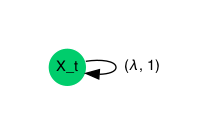

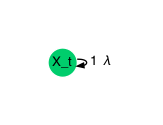

In [62]:
t = [
        {'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 1}
        ]

net = me.Network('net_div_exp')
net.structure(t)

node_settings = {
    'X_t': {'label': 'X_t', 'color': "#00CD6C"}
}

edge_settings = {
    'l': {'label': '<I>&lambda;</I>', 'color': None}
}

me.plots.net_main_plot(net, node_settings=node_settings, edge_settings=edge_settings)
a = me.plots.net_hidden_plot(net, node_settings=node_settings, edge_settings=edge_settings)

[ 0.          0.78947368  1.57894737  2.36842105  3.15789474  3.94736842
  4.73684211  5.52631579  6.31578947  7.10526316  7.89473684  8.68421053
  9.47368421 10.26315789 11.05263158 11.84210526 12.63157895 13.42105263
 14.21052632 15.        ]
[ 0.          0.51724138  1.03448276  1.55172414  2.06896552  2.5862069
  3.10344828  3.62068966  4.13793103  4.65517241  5.17241379  5.68965517
  6.20689655  6.72413793  7.24137931  7.75862069  8.27586207  8.79310345
  9.31034483  9.82758621 10.34482759 10.86206897 11.37931034 11.89655172
 12.4137931  12.93103448 13.44827586 13.96551724 14.48275862 15.        ]


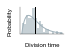

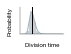

In [274]:
# broad and tight waiting time distributions
# broad
theta = 1.0/0.2
steps = 2
bins = np.linspace(0.0, 15.0, num=20)
print(bins)

x = np.linspace(0, 15, 1000)
y = stats.gamma.pdf(x, a=steps, loc=0, scale=theta/steps) # 'a' is shape
rvs = stats.gamma.rvs(a=steps, loc=0, scale=theta/steps, size=100) # size=10000

fig, ax = plt.subplots(figsize=(0.8, 0.5))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.hist(rvs, bins=bins, density=True, color=grey, alpha=0.6)
ax.plot(x, y, linewidth=1.0, color=grey, label='')
plt.axvline(x=theta, linewidth=0.8, color='black')

# optional: hide numbers on axis
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

# leg = plt.legend()
# leg.get_frame().set_edgecolor('lightgrey')
plt.ylim((-0.003, None))
plt.xlabel('Division time')
plt.ylabel('Probability') # plt.ylabel('Probability density function')
plt.savefig(f'paper_figures/waiting_time_distr_scheme_broad_g2.pdf', bbox_inches='tight')

# tight
theta = 1.0/0.255
steps = 15
bins = np.linspace(0.0, 15.0, num=30)
print(bins)

x = np.linspace(0, 15, 1000)
y = stats.gamma.pdf(x, a=steps, loc=0, scale=theta/steps) # 'a' is shape
rvs = stats.gamma.rvs(a=steps, loc=0, scale=theta/steps, size=100) # size=10000

fig, ax = plt.subplots(figsize=(0.8, 0.5))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.hist(rvs, bins=bins, density=True, color=grey, alpha=0.6)
ax.plot(x, y, linewidth=1.0, color=grey, label='')
plt.axvline(x=theta, linewidth=0.8, color='black')

# optional: hide numbers on axis
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

# leg = plt.legend()
# leg.get_frame().set_edgecolor('lightgrey')
plt.ylim((-0.005, None))
plt.xlabel('Division time')
plt.ylabel('Probability') # plt.ylabel('Probability density function')
plt.savefig(f'paper_figures/waiting_time_distr_scheme_broad_g15.pdf', bbox_inches='tight')

In [170]:
# broad model simulations
t = [
        {'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 2}
        ]

net = me.Network('net_div_g2')
net.structure(t)

num_iter = 10 # 3
alpha_val = 0.6 # 0.8
variables = {'X_t': ('X_t', )}
initial_values = {'X_t': 1}
theta_values = {'l': 0.2}
time_values = np.linspace(0.0, 10.0, num=10000, endpoint=True)

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sims = np.array(res_list)

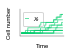

In [171]:
# settings = {
#     'X_t': {'label': '$X_t$', 'color': cactiv}
# }

# plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
# me.plots.sim_counts_plot(sim, settings=settings)
    
plt.rcParams.update({'figure.figsize': (0.8, 0.5)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.plot(time_values, sims[0, 0, :], color=cactiv, linewidth=1.0, zorder=1000, label='$X_t$', alpha=alpha_val) # color='darkgreen'
for trace_i in range(sims.shape[0]-1):
        plt.plot(time_values, sims[trace_i+1, 0, :], color=cactiv, linewidth=1.0, zorder=1000, alpha=alpha_val) # color='darkgreen'

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

# ax.set_ylim([-0.3, None])
# leg = plt.legend()
# plt.legend(frameon=False)
# leg.get_frame().set_edgecolor('lightgrey')
plt.xlabel('Time')
plt.ylabel('Cell number')
plt.ylim(-0.2, 10)
plt.legend()
#plt.ylabel('#Cells')
plt.savefig(f'paper_figures/sim_div_scheme_g2.pdf', bbox_inches='tight')

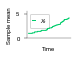

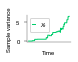

In [172]:
# mean and variance plots
plt.rcParams.update({'figure.figsize': (0.8, 0.5)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.plot(time_values, np.mean(sims[:, 0, :], axis=0),
        color=cactiv, linewidth=1.0, zorder=1000, label='$X_t$')

ax.set_xticklabels([])
plt.tick_params(axis = "x", which = "both",length=0)

plt.xlabel('Time')
plt.ylabel('Sample mean')
plt.ylim(0.0, 5.5)
plt.legend()
plt.savefig(f'paper_figures/sim_div_scheme_sample_mean_g2.pdf', bbox_inches='tight')

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.plot(time_values, np.var(sims[:, 0, :], axis=0, ddof=1),
        color=cactiv, linewidth=1.0, zorder=1000, label='$X_t$')

ax.set_xticklabels([])
plt.tick_params(axis = "x", which = "both",length=0)

plt.xlabel('Time')
plt.ylabel('Sample variance')
plt.legend()
plt.savefig(f'paper_figures/sim_div_scheme_sample_var_g2.pdf', bbox_inches='tight')

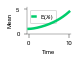

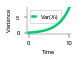

4.475012567019526

In [173]:
# moment solutions
sim = me.Simulation(net)
res = sim.simulate('moments', variables, initial_values, theta_values, time_values)

settings = {
    'X_t': {'label': 'E$(X_t)$', 'color': cactiv},
}
me.plots.sim_mean_plot(sim, y_lim=(0.0, 5.5), settings=settings, save='paper_figures/sim_div_mom_scheme_g2_mean.pdf')

settings = {
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': cactiv},
}
me.plots.sim_variance_plot(sim, settings=settings, save='paper_figures/sim_div_mom_scheme_g2_var.pdf')

# last mean time point
sim.sim_moments_res[0][0, -1]

In [143]:
# tight model simulations
t = [
        {'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 15}
        ]

net = me.Network('net_div_g15')
net.structure(t)

num_iter = 10 # 3
alpha_val = 0.6 # 0.8
variables = {'X_t': ('X_t', )}
initial_values = {'X_t': 1}
theta_values = {'l': 0.255}
time_values = np.linspace(0.0, 10.0, num=10000, endpoint=True)

sim = me.Simulation(net)
res_list = list()

for __ in range(num_iter):
    res_list.append(sim.simulate('gillespie', variables, initial_values, theta_values, time_values)[1])

sims = np.array(res_list)

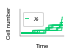

In [160]:
# settings = {
#     'X_t': {'label': '$X_t$', 'color': cactiv}
# }

# plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
# me.plots.sim_counts_plot(sim, settings=settings)
    
plt.rcParams.update({'figure.figsize': (0.8, 0.5)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.plot(time_values, sims[0, 0, :], color=cactiv, linewidth=1.0, zorder=1000, label='$X_t$', alpha=0.8) # color='darkgreen'
for trace_i in range(sims.shape[0]-1):
        plt.plot(time_values, sims[trace_i+1, 0, :], color=cactiv, linewidth=1.0, zorder=1000, alpha=0.8) # color='darkgreen'

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

# ax.set_ylim([-0.3, None])
# leg = plt.legend()
# plt.legend(frameon=False)
# leg.get_frame().set_edgecolor('lightgrey')
plt.xlabel('Time')
plt.ylabel('Cell number')
plt.ylim(-0.2, 10)
plt.legend()
#plt.ylabel('#Cells')
plt.savefig(f'paper_figures/sim_div_scheme_g15.pdf', bbox_inches='tight')

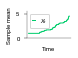

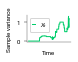

In [161]:
# mean and variance plots
plt.rcParams.update({'figure.figsize': (0.8, 0.5)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.plot(time_values, np.mean(sims[:, 0, :], axis=0),
        color=cactiv, linewidth=1.0, zorder=1000, label='$X_t$')

ax.set_xticklabels([])
plt.tick_params(axis = "x", which = "both",length=0)

plt.xlabel('Time')
plt.ylabel('Sample mean')
plt.ylim(0.0, 5.5)
plt.legend()
plt.savefig(f'paper_figures/sim_div_scheme_sample_mean_g15.pdf', bbox_inches='tight')

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.plot(time_values, np.var(sims[:, 0, :], axis=0, ddof=1),
        color=cactiv, linewidth=1.0, zorder=1000, label='$X_t$')

ax.set_xticklabels([])
plt.tick_params(axis = "x", which = "both",length=0)

plt.xlabel('Time')
plt.ylabel('Sample variance')
plt.legend()
plt.savefig(f'paper_figures/sim_div_scheme_sample_var_g15.pdf', bbox_inches='tight')

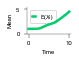

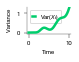

4.48138465306211

In [162]:
# moment solutions
sim = me.Simulation(net)
res = sim.simulate('moments', variables, initial_values, theta_values, time_values)

settings = {
    'X_t': {'label': 'E$(X_t)$', 'color': cactiv},
}
me.plots.sim_mean_plot(sim, y_lim=(0.0, 5.5), settings=settings, save='paper_figures/sim_div_mom_scheme_g15_mean.pdf')

settings = {
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': cactiv},
}
me.plots.sim_variance_plot(sim, settings=settings, save='paper_figures/sim_div_mom_scheme_g15_var.pdf')

# last mean time point
sim.sim_moments_res[0][0, -1]

###### waiting time distr schemes

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54.]


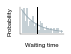

In [315]:
# exp
theta = 20
steps = 1
bins = np.linspace(0.0, 54.0, num=28)
print(bins)

x = np.linspace(0, 54, 1000)
y = stats.expon.pdf(x, scale=theta, loc=0) # 'a' is shape
rvs = stats.expon.rvs(scale=theta, loc=0, size=100) # size=10000

fig, ax = plt.subplots(figsize=(0.8, 0.5))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.hist(rvs, bins=bins, density=True, color=grey, alpha=0.6)
ax.plot(x, y, linewidth=1.0, color=grey, label='')
plt.axvline(x=theta, linewidth=0.8, color='black')

# optional: hide numbers on axis
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

# leg = plt.legend()
# leg.get_frame().set_edgecolor('lightgrey')
plt.ylim((-0.003, None))
plt.xlabel('Waiting time')
plt.ylabel('Probability') # plt.ylabel('Probability density function')
plt.savefig(f'paper_figures/waiting_time_distr_scheme_exp.pdf', bbox_inches='tight')

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54.]


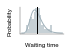

In [320]:
# gamma
theta = 20
steps = 7
bins = np.linspace(0.0, 54.0, num=28)
print(bins)

x = np.linspace(0, 54, 1000)
y = stats.gamma.pdf(x, a=steps, loc=0, scale=theta/steps) # 'a' is shape
rvs = stats.gamma.rvs(a=steps, loc=0, scale=theta/steps, size=100) # size=10000

fig, ax = plt.subplots(figsize=(0.8, 0.5))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.hist(rvs, bins=bins, density=True, color=grey, alpha=0.6)
ax.plot(x, y, linewidth=1.0, color=grey, label='')
plt.axvline(x=theta, linewidth=0.8, color='black')

# optional: hide numbers on axis
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

# leg = plt.legend()
# leg.get_frame().set_edgecolor('lightgrey')
plt.ylim((-0.003, None))
plt.xlabel('Waiting time')
plt.ylabel('Probability') # plt.ylabel('Probability density function')
plt.savefig(f'paper_figures/waiting_time_distr_scheme_gamma.pdf', bbox_inches='tight')

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54.]
0.20102651839178787
0.5988023952095808
0.20017108639863132
1.0
9999


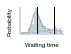

In [323]:
# phase type (ph)
theta1 = 1/(0.047 / 2) # 40
theta2 = 20
theta3 = 1/(0.026 / 2) # 76

steps1 = 10
steps2 = 14 
steps3 = 18

bins = np.linspace(0.0, 54.0, num=28)
print(bins)
w1 = steps1/theta1 / (steps1/theta1 + steps2/theta2 + steps3/theta3)
w2 = steps2/theta2 / (steps1/theta1 + steps2/theta2 + steps3/theta3)
w3 = steps3/theta3 / (steps1/theta1 + steps2/theta2 + steps3/theta3)
print(w1)
print(w2)
print(w3)
print(w1 + w2 + w3)

x = np.linspace(0, 54, 1000)
y1 = stats.gamma.pdf(x, a=steps1, loc=0, scale=theta1/steps1) # 'a' is shape
y2 = stats.gamma.pdf(x, a=steps2, loc=0, scale=theta2/steps2) # 'a' is shape
# y3 = stats.gamma.pdf(x, a=steps3, loc=0, scale=theta3/steps3) # 'a' is shape

rvs1 = stats.gamma.rvs(a=steps1, loc=0, scale=theta1/steps1, size=int(100 * w1))
rvs2 = stats.gamma.rvs(a=steps2, loc=0, scale=theta2/steps2, size=int(100 * w2))
# rvs3 = stats.gamma.rvs(a=steps3, loc=0, scale=theta3/steps3, size=int(10000 * w3))
print(int(10000 * w1) + int(10000 * w2) + int(10000 * w3))

fig, ax = plt.subplots(figsize=(0.8, 0.5))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# the '0.5' in the weights come from the 2-hour interval in the bins
# ax.hist(rvs1, bins=bins, weights=np.full(rvs1.shape, 0.5/10000), density=False, color='gold', alpha=0.6)
# ax.hist(rvs2, bins=bins, weights=np.full(rvs2.shape, 0.5/10000), density=False, color='orange', alpha=0.6)
# ax.hist(rvs3, bins=bins, weights=np.full(rvs3.shape, 0.5/10000), density=False, color='dodgerblue', alpha=0.8)

# combined hist
ax.hist(np.concatenate([rvs1, rvs2]), bins=bins, 
        weights=np.full((rvs1.shape[0] + rvs2.shape[0],), 0.5/100), 
        density=False, color=grey, alpha=0.6)

ax.plot(x, w1 * y1, linewidth=1.0, color=grey, label='', 
        linestyle='--', zorder=100)
ax.plot(x, w2 * y2, linewidth=1.0, color=grey, label='', 
        linestyle='--', zorder=100)
# ax.plot(x, w3 * y3, linewidth=1.0, color='dodgerblue', label='')

ax.plot(x, w1 * y1 + w2 * y2, linewidth=1.0, color=grey, 
        label='', zorder=200) # + w3 * y3
plt.axvline(x=theta1, linewidth=0.8, color='black', zorder=250)
plt.axvline(x=theta2, linewidth=0.8, color='black', zorder=250)

# optional: hide numbers on axis
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

# leg = plt.legend()
# leg.get_frame().set_edgecolor('lightgrey')
plt.ylim((-0.003, None))
plt.xlabel('Waiting time')
plt.ylabel('Probability') # plt.ylabel('Probability density function')
plt.savefig(f'paper_figures/waiting_time_distr_scheme_ph.pdf', bbox_inches='tight')

In [24]:
np.concatenate([rvs1, rvs2]).shape

(7998,)

###### moment differential equations for simple division model
###### (also see Goodnotes, for a manual derivation)

In [324]:
t = [
        {'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'l', 'type': 'S -> S + S', 'reaction_steps': 2}
        ]

net = me.Network('net_div_g2')
net.structure(t)

num_iter = 3
initial_values = {'X_t': 1}
theta_values = {'l': 0.2}
time_values = np.linspace(0.0, 10.0, num=10000, endpoint=True)
variables = {'X_t': ('X_t', )}


sim = me.Simulation(net)
res = sim.simulate('moments', initial_values, theta_values, time_values, variables)

In [347]:
print(sim.sim_moments.moment_order_hidden)
print('\n')
print(sim.sim_moments.moment_pde)
print('\n')
meqs = sim.sim_moments.moment_eqs
meqs = [s.replace('theta[0]', 'l') for s in meqs]
meqs = [s.replace('m[0]', 'E(X_0)') for s in meqs]
meqs = [s.replace('m[1]', 'E(X_1)') for s in meqs]
meqs = [s.replace('m[2]', 'E(X_0(X_0-1))') for s in meqs]
meqs = [s.replace('m[3]', 'E(X_0 X_1)') for s in meqs]
meqs = [s.replace('m[4]', 'E(X_1(X_1-1))') for s in meqs]
meqs[0] = 'd/dt E(X_0) = ' + meqs[0]
meqs[1] = 'd/dt E(X_1) = ' + meqs[1]
meqs[2] = 'd/dt E(X_0(X_0-1)) = ' + meqs[2]
meqs[3] = 'd/dt E(X_0 X_1) = ' + meqs[3]
meqs[4] = 'd/dt E(X_1(X_1-1)) = ' + meqs[4]
for e in meqs:
    print(e)

# E(X_0) = m[0]
# E(X_1) = m[1]
# E(X_0(X_0-1)) = m[2]
# E(X_0 X_1) = m[3]
# E(X_1(X_1-1)) = m[4]

[[('Z_0__centric',), ('Z_0__module_0__0',)], [('Z_0__centric', 'Z_0__centric'), ('Z_0__centric', 'Z_0__module_0__0'), ('Z_0__module_0__0', 'Z_0__module_0__0')]]


2.0 * theta_0_q * (z_0__module_0__0_q - z_0__centric_q) * diff(F(z_0__centric_q, z_0__module_0__0_q), z_0__centric_q) + 2.0 * theta_0_q * (z_0__centric_q * z_0__centric_q - z_0__module_0__0_q) * diff(F(z_0__centric_q, z_0__module_0__0_q), z_0__module_0__0_q)


d/dt E(X_0) = -2.0*E(X_0)*l + 4.0*E(X_1)*l
d/dt E(X_1) = 2.0*E(X_0)*l - 2.0*E(X_1)*l
d/dt E(X_0(X_0-1)) = 4.0*E(X_1)*l - 4.0*E(X_0(X_0-1))*l + 8.0*E(X_0 X_1)*l
d/dt E(X_0 X_1) = 2.0*E(X_0(X_0-1))*l - 4.0*E(X_0 X_1)*l + 4.0*E(X_1(X_1-1))*l
d/dt E(X_1(X_1-1)) = 4.0*E(X_0 X_1)*l - 4.0*E(X_1(X_1-1))*l


##### Figure 2 <a id='figure2'></a> [↑](#top)

##### Figure 3 <a id='figure3'></a> [↑](#top)

###### Network scheme

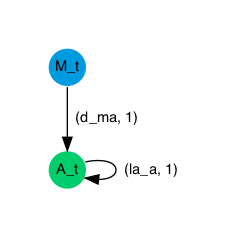

In [24]:
res = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))
net = res[0].net

# need hex colors here
# "#FF1F5B", "#00CD6C", "#009ADE"
node_settings = {
    'M_t': {'label': 'M_t', 'color': "#009ADE"}, # "#FFC61E", "#009ADE"
    'A_t': {'label': 'A_t', 'color': "#00CD6C"}
}
me.plots.net_main_plot(net, node_settings=node_settings, save='paper_figures/model_scheme_cd44.pdf')
# me.plots.net_hidden_plot(net, layout='dot')

###### Data panel

In [5]:
data = pickle.load(open('count_data_cd44_manual_counting_18_01_14_filtered_sigma022.pickle', 'rb'))

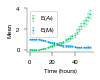

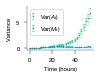

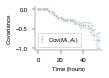

In [68]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.data_mean_plot(data, x_label='Time (hours)', save='paper_figures/data_cd44_mean.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.data_variance_plot(data, x_label='Time (hours)', save='paper_figures/data_cd44_var.pdf', settings=settings)

settings = {
    ('M_t', 'A_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.data_covariance_plot(data, x_label='Time (hours)', save='paper_figures/data_cd44_cov.pdf', settings=settings)

In [6]:
print(data.data_variables)
print(data.data_counts.shape)
print(data.data_counts[26, 0, :])
print(data.data_counts[26, 1, :])
print(np.amax(data.data_counts))

['A_t', 'M_t']
(44, 2, 28)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3.
 4. 4. 5. 5.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
9.0


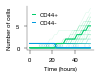

In [7]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

trace_emph = 26
for trace_i in range(data.data_counts.shape[0]):
    if trace_i!=trace_emph:
        plt.plot(data.data_time_values, data.data_counts[trace_i, 0, :], color=cactiv, alpha=0.15, linewidth=0.5)
        plt.plot(data.data_time_values, data.data_counts[trace_i, 1, :], color=cnaive, alpha=0.15, linewidth=0.5)
    else:
        plt.plot(data.data_time_values, data.data_counts[trace_i, 0, :], color=cactiv, alpha=1.0, linewidth=1.0, label='CD44+', zorder=1000) # color='darkgreen'
        plt.plot(data.data_time_values, data.data_counts[trace_i, 1, :], color=cnaive, alpha=1.0, linewidth=1.0, label='CD44-', zorder=1000) # color='darkblue'
        
# ax.set_ylim([-0.3, None])
leg = plt.legend()
plt.legend(frameon=False)
# leg.get_frame().set_edgecolor('lightgrey')
plt.xlabel('Time (hours)')
plt.ylabel('Number of cells')
plt.savefig(f'paper_figures/data_cd44_single_well_traces.pdf', bbox_inches='tight')

###### Cell number histograms

In [7]:
data = pickle.load(open('count_data_cd44_manual_counting_18_01_14_filtered_sigma022.pickle', 'rb'))

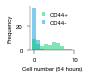

In [7]:
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
time_index = -1 # last time point
settings = {
    'M_t': {'label': 'CD44-', 'color': cnaive, 'opacity': 0.5},
    'A_t': {'label': 'CD44+', 'color': cactiv, 'opacity': 0.5}
    }
me.plots.data_hist_variables_plot(data, time_index, normalised=False, settings=settings,
                                  x_label='Cell number (54 hours)', save='paper_figures/data_cd44_count_hist.pdf')

In [8]:
# best phase-type model
res1 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
res2 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))

# res = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par3.pickle', 'rb'))

res = res1 + res2
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)

In [49]:
res[0].net.net_rates_identifier

{'theta_0': 'alpha_F',
 'theta_1': 'alpha_S',
 'theta_2': 'alpha_T',
 'theta_3': 'lambda'}

In [50]:
# best model
est_i = list(model_probs).index(max(model_probs))
print(est_i, net_names[est_i])

# 9th best model
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
est_i = net_names.index(net_names_sorted[8])
print(est_i, net_names[est_i])

# 5th best model
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
est_i = net_names.index(net_names_sorted[4])
print(est_i, net_names[est_i])

348 net_alphaF6_alphaS6_alphaT6_lambda14
397 net_alphaF6_alphaS8_alphaT14_lambda14
475 net_alphaF8_alphaS8_alphaT18_lambda18


In [43]:
est = res[59]
print(est.net.net_name)

net_3_20


In [24]:
num_iter = 1000 # 10000
theta_rand = np.random.choice(est.bay_est_samples_weighted.shape[0], num_iter)
time_values = est.data.data_time_values
initial_values = {'N_t': 1, 'A_t': 0, 'P1_t': 0, 'P2_t': 0, 'P3_t': 0}
variables = {'M_t': ('N_t', 'P1_t', 'P2_t', 'P3_t'), 'A_t': ('A_t', )}

sim = me.Simulation(est.net)
res_list = list()

In [25]:
for i in range(num_iter):
    a1, a2, a3, l = est.bay_est_samples_weighted[theta_rand[i], :]
    theta_values = {'alpha_F': a1, 'alpha_S': a2, 
                    'alpha_T': a3, 'lambda': l}
    
    res_list.append(sim.simulate('gillespie', initial_values, theta_values, time_values, variables)[1])

in_silico_counts = np.array(res_list)

In [26]:
data = me.Data('data_best_phase_model')
data.load(['A_t', 'M_t'], time_values, in_silico_counts, bootstrap_samples=1000, basic_sigma=1.0/num_iter)

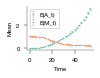

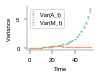

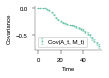

In [36]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
me.plots.data_mean_plot(data, save='paper_figures/data_in_sil_5thbestPH_mean.pdf')
me.plots.data_variance_plot(data, save='paper_figures/data_in_sil_5thbestPH_var.pdf')
me.plots.data_covariance_plot(data, save='paper_figures/data_in_sil_5thbestPH_cov.pdf')

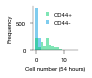

In [27]:
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
time_index = -1 # last time point
settings = {
    'M_t': {'label': 'CD44-', 'color': cnaive, 'opacity': 0.5},
    'A_t': {'label': 'CD44+', 'color': cactiv, 'opacity': 0.5}
    }
me.plots.data_hist_variables_plot(data, time_index, normalised=False, settings=settings,
                                  x_label='Cell number (54 hours)', 
                                  save='paper_figures/data_cd44_count_hist_5thPHmodel.pdf')

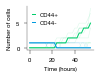

In [32]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

trace_emph = 0
for trace_i in range(10): # data.data_counts.shape[0]):
    if trace_i!=trace_emph:
        plt.plot(data.data_time_values, data.data_counts[trace_i, 0, :], color=cactiv, alpha=0.15, linewidth=0.5)
        plt.plot(data.data_time_values, data.data_counts[trace_i, 1, :], color=cnaive, alpha=0.15, linewidth=0.5)
    else:
        plt.plot(data.data_time_values, data.data_counts[trace_i, 0, :], color=cactiv, alpha=1.0, linewidth=1.0, label='CD44+', zorder=1000) # color='darkgreen'
        plt.plot(data.data_time_values, data.data_counts[trace_i, 1, :], color=cnaive, alpha=1.0, linewidth=1.0, label='CD44-', zorder=1000) # color='darkblue'
        
# ax.set_ylim([-0.3, None])
leg = plt.legend()
plt.legend(frameon=False)
# leg.get_frame().set_edgecolor('lightgrey')
plt.xlabel('Time (hours)')
plt.ylabel('Number of cells')
plt.savefig(f'paper_figures/data_cd44_swtraces_5thbestPH.pdf', bbox_inches='tight')

In [32]:
res1 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))
res2 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))
res3 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
data = res[0].data
print(sum(['alphaF' in name for name in net_names]))

100 196 588 884
784


In [18]:
# set model prior to give classes same weight
mprior = np.array([0.25] + [0.25/99]*99 + [0.25/196]*196 + [0.25/588]*588)
print(sum(mprior))
print(len(mprior))

1.0000000000000184
884


In [45]:
# res = [est]
celltype = 1 # 0 or 1 (active, naive)
time_point = -1 # last time point
sample_n = 100 # 1000 # posterior samples of cell histograms; typically 1000-10000
sim_n = 50 # 500 # simulation repeats per given model and theta; ideally, inf
count_max = 16
y = hist_cell_counts_samples(res, celltype, time_point, sample_n, count_max, sim_n, mprior)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[ 0.  0. 49. 51.]


In [46]:
print(y.shape)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)

(16, 100)


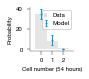

In [47]:
# compute model histogram over all models
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

linelow = 44*y_95_lower/sim_n
line = 44*y_median/sim_n
lineupp = 44*y_95_upper/sim_n
errlow = line-linelow
errupp = lineupp-line

# plt.fill_between(range(count_max), linelow, line, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100)
# plt.plot(range(count_max), line, color=cnaive, zorder=200, linewidth=1.0)
# plt.fill_between(range(count_max), line, lineupp, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100,
#                 label='Models')
cutplot = 3
plt.errorbar(list(range(count_max))[:cutplot], line[:cutplot], yerr=np.array([errlow, errupp])[:, :cutplot],
            color=cnaive, linewidth=1.0, capsize=1.0,
             zorder=100, markersize=2, fmt='.', label='Model')

plt.hist(res[0].data.data_counts[:, 1, -1], bins=np.linspace(-0.5, 9.5, num=11), 
         color='black', alpha=0.1, label='Data')
plt.xticks([0, 1, 2])
plt.xlim(None, 3)
plt.ylim(-1.5, None)
plt.xlabel('Cell number (54 hours)')
plt.ylabel('Probability')
plt.legend()
plt.savefig(f'paper_figures/hist_cd44_naive_688_bands.pdf', bbox_inches='tight') # _thin4

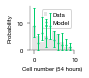

In [43]:
# compute model histogram over all models
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

linelow = 44*y_95_lower/sim_n
line = 44*y_median/sim_n
lineupp = 44*y_95_upper/sim_n
errlow = line-linelow
errupp = lineupp-line

# plt.fill_between(range(count_max), linelow, line, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100)
# plt.plot(range(count_max), line, color=cactiv, zorder=200, linewidth=1.0)
# plt.fill_between(range(count_max), line, lineupp, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100,
#                 label='Model')
cutplot = 10
plt.errorbar(list(range(count_max))[:cutplot], line[:cutplot], 
             yerr=np.array([errlow, errupp])[:, :cutplot],
            color=cactiv, linewidth=1.0, capsize=1.0,
             zorder=100, markersize=2, fmt='.', label='Model')

plt.hist(res[0].data.data_counts[:, 0, -1], bins=np.linspace(-0.5, 9.5, num=11), 
         color='black', alpha=0.1, label='Data')

plt.xlim(-1, 10)
plt.xlabel('Cell number (54 hours)')
plt.ylabel('Probability')
plt.legend()
plt.savefig(f'paper_figures/hist_cd44_active_688_band.pdf', bbox_inches='tight') # _thin4

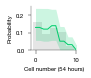

In [44]:
def bin_counts(arr):
    # 1d input array with even length
    # create with same length
    arr_binned = np.zeros((arr.shape[0]))
    
    # loop over every second element
    for i in range(int(arr_binned.shape[0]/2)):
        bin_val = (arr[2*i] + arr[2*i+1])/2.0
        arr_binned[2*i] = bin_val
        arr_binned[2*i+1] = bin_val
    return arr_binned

y_95_lower_binned = bin_counts(y_95_lower)
y_median_binned = bin_counts(y_median)
y_95_upper_binned = bin_counts(y_95_upper)

# compute model histogram over all models
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.fill_between(range(count_max), y_95_lower_binned/sim_n, y_median_binned/sim_n, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100)
plt.plot(range(count_max), y_median_binned/sim_n, color=cactiv, zorder=200, linewidth=1.0)
plt.fill_between(range(count_max), y_median_binned/sim_n, y_95_upper_binned/sim_n, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(range(count_max), 44*y_95_upper/sim_n, color=cactiv, zorder=100, alpha=0.5)
# plt.plot(range(count_max), 44*y_95_lower/sim_n, color=cactiv, zorder=100, alpha=0.5)

plt.hist(data.data_counts[:, 0, -1], bins=np.linspace(-0.5, 9.5, num=6), color='black', alpha=0.1, density=True)
plt.xlim(-1, 10)
plt.xlabel('Cell number (54 hours)')
plt.ylabel('Probability')
plt.savefig(f'paper_figures/hist_cd44_active_2bin.pdf', bbox_inches='tight')

###### Event analysis

In [49]:
data = pickle.load(open('count_data_cd44_manual_counting_18_01_14_filtered_sigma022.pickle', 'rb'))

In [50]:
data.events_find_all()

In [51]:
print(event_percentage(data.event_all_first_change_from_inital_conditions))
print(event_percentage(data.event_all_first_cell_type_conversion))
print(event_percentage(data.event_all_first_cell_count_increase))
print(event_percentage(data.event_all_first_cell_count_increase_after_cell_type_conversion))
print(event_percentage(data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion))
print(event_percentage(data.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion))

84.0909090909091
81.81818181818181
70.45454545454545
68.18181818181819
61.36363636363637
45.45454545454545


In [52]:
# events of the data
e_act_data = event_percentage(data.event_all_first_cell_type_conversion)
e_div1_data = event_percentage(data.event_all_first_cell_count_increase_after_cell_type_conversion)
e_div2_data = event_percentage(data.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion)
e_div3_data = event_percentage(data.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion)

In [53]:
# bootstrapping of microwells to get 95% uncertainty intervals for data events
nwells = data.data_counts.shape[0]
inds = np.array(range(0, nwells))
nsamples = 5000

e_act_data_samples = np.zeros(nsamples)
e_div1_data_samples = np.zeros(nsamples)
e_div2_data_samples = np.zeros(nsamples)
e_div3_data_samples = np.zeros(nsamples)

variables = data.data_variables
time_values = data.data_time_values

for i in range(nsamples):
    wellinds = np.random.choice(inds, replace=True, size=nwells)
    data_counts_sample = np.copy(data.data_counts[wellinds, :, :])
    
    data_btstrp = me.Data('data_btstrp')
    data_btstrp.load(variables, time_values, data_counts_sample, bootstrap_samples=2)
    data_btstrp.events_find_all()
    
    e_act_data_samples[i] = event_percentage(data_btstrp.event_all_first_cell_type_conversion)
    e_div1_data_samples[i] = event_percentage(data_btstrp.event_all_first_cell_count_increase_after_cell_type_conversion)
    e_div2_data_samples[i] = event_percentage(data_btstrp.event_all_second_cell_count_increase_after_first_cell_count_increase_after_cell_type_conversion)
    e_div3_data_samples[i] = event_percentage(data_btstrp.event_all_third_cell_count_increase_after_first_and_second_cell_count_increase_after_cell_type_conversion)
    
print(np.percentile(e_act_data_samples, 50.0), np.percentile(e_act_data_samples, 2.5), np.percentile(e_act_data_samples, 97.5))
print(np.percentile(e_div1_data_samples, 50.0), np.percentile(e_div1_data_samples, 2.5), np.percentile(e_div1_data_samples, 97.5))
print(np.percentile(e_div2_data_samples, 50.0), np.percentile(e_div2_data_samples, 2.5), np.percentile(e_div2_data_samples, 97.5))
print(np.percentile(e_div3_data_samples, 50.0), np.percentile(e_div3_data_samples, 2.5), np.percentile(e_div3_data_samples, 97.5))

81.81818181818181 70.45454545454545 93.18181818181819
68.18181818181819 54.54545454545455 81.81818181818181
61.36363636363637 47.72727272727273 75.0
45.45454545454545 31.818181818181817 61.36363636363637


In [54]:
res1 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))
res2 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))
res3 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
data = res[0].data
print(sum(['alphaF' in name for name in net_names]))

100 196 588 884
784


In [55]:
# set model prior to give classes same weight
mprior = np.array([0.25] + [0.25/99]*99 + [0.25/196]*196 + [0.25/588]*588)
print(sum(mprior))
print(len(mprior))

1.0000000000000184
884


In [56]:
data.data_variables

['A_t', 'M_t']

In [59]:
# paper run should be like: res, 1000, 500, mprior
(e_act_model_samples, e_div1_model_samples,
    e_div2_model_samples, e_div3_model_samples) = event_model_samples(
                                            res, 100, 50, mprior) # 1000, 500

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[ 0.  0. 49. 51.]


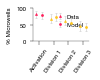

In [60]:
# plot copied from plot comment (fig_dots_w_mult_bars)
val_obj = np.array([
        np.array([[e_act_data, e_act_data - np.percentile(e_act_data_samples, 2.5), np.percentile(e_act_data_samples, 97.5) - e_act_data], 
                  [np.percentile(e_act_model_samples, 50.0), np.percentile(e_act_model_samples, 50.0) - np.percentile(e_act_model_samples, 2.5), np.percentile(e_act_model_samples, 97.5) - np.percentile(e_act_model_samples, 50.0)]]),
        np.array([[e_div1_data, e_div1_data - np.percentile(e_div1_data_samples, 2.5), np.percentile(e_div1_data_samples, 97.5) - e_div1_data], 
                  [np.percentile(e_div1_model_samples, 50.0), np.percentile(e_div1_model_samples, 50.0) - np.percentile(e_div1_model_samples, 2.5), np.percentile(e_div1_model_samples, 97.5) - np.percentile(e_div1_model_samples, 50.0)]]),
        np.array([[e_div2_data, e_div2_data - np.percentile(e_div2_data_samples, 2.5), np.percentile(e_div2_data_samples, 97.5) - e_div2_data], 
                  [np.percentile(e_div2_model_samples, 50.0), np.percentile(e_div2_model_samples, 50.0) - np.percentile(e_div2_model_samples, 2.5), np.percentile(e_div2_model_samples, 97.5) - np.percentile(e_div2_model_samples, 50.0)]]),
        np.array([[e_div3_data, e_div3_data - np.percentile(e_div3_data_samples, 2.5), np.percentile(e_div3_data_samples, 97.5) - e_div3_data], 
                  [np.percentile(e_div3_model_samples, 50.0), np.percentile(e_div3_model_samples, 50.0) - np.percentile(e_div3_model_samples, 2.5), np.percentile(e_div3_model_samples, 97.5) - np.percentile(e_div3_model_samples, 50.0)]])
        ], dtype=object)

attributes = {0: ('Activation', [cwact, cwact]),
              1: ('Division 1', [cwdiv, cwdiv]),
              2: ('Division 2', [cwdiv, cwdiv]),
              3: ('Division 3', [cwdiv, cwdiv])}

legend_attr = [('blue', 'x'), ('limegreen', 'y'), ('red', 'z')]

# initialise figure and axis settings
plt.rcParams.update({'figure.figsize': (1.0, 0.6)})

plt.figure()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# actual plotting
for val_ind in range(val_obj.shape[0]):
    color_list = attributes[val_ind][1]
    dots_per_categ = val_obj[val_ind].shape[0]

    if dots_per_categ == 1:
        x_pos = [val_ind + 1]
    elif dots_per_categ == 2:
        x_pos = [val_ind + 1 - 0.2, val_ind + 1 + 0.2]
    elif dots_per_categ == 3:
        x_pos = [val_ind + 1 - 0.2, val_ind + 1, val_ind + 1 + 0.2]

    for dot_ind in range(dots_per_categ):
        plt.errorbar(x_pos[dot_ind], val_obj[val_ind][dot_ind, 0],
                    yerr=val_obj[val_ind][dot_ind, 1:].reshape(2,1),
                    fmt='^' if dot_ind==0 else 'o', capsize=1, elinewidth=0.7, markeredgewidth=0.7,
                    markersize=2, markeredgecolor=color_list[dot_ind],
                    color=color_list[dot_ind], ecolor='lightgrey', zorder=1000,
                    label=['Data', 'Model'][dot_ind] if val_ind==0 else None)

# add x axis ticks
plt.xticks([val_ind + 1 for val_ind in range(val_obj.shape[0])],
                [attributes[val_ind][0] for val_ind in range(val_obj.shape[0])], rotation=55)

# add legend manually
# plt.legend(handles=[mpatches.Patch(color=leg[0], label=leg[1]) for leg in legend_attr])
plt.legend(frameon=False, loc='upper right')

plt.ylim(0, 100) # ylim(35, 90)
plt.ylabel('% Microwells')
plt.savefig('paper_figures/event_analysis_01.pdf', bbox_inches='tight')

###### Model results

###### minimal model results (Markov+Erlang)

In [5]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))

In [6]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]

sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = np.array(log_evids)[sort_inds]

print(model_probs_sorted[:10])
print(log_evids_sorted[:10])
print(net_names_sorted[:10])

[0.15104273 0.14571297 0.12672787 0.10650158 0.10627389 0.08805198
 0.06527255 0.0647611  0.0494027  0.03840488]
[208.71859475 208.68267069 208.54307402 208.3691918  208.3670516
 208.17895931 207.87960353 207.87173706 207.60103714 207.34921655]
['net_3_20' 'net_3_19' 'net_3_18' 'net_3_17' 'net_3_16' 'net_3_15'
 'net_3_13' 'net_3_14' 'net_3_12' 'net_3_11']


In [7]:
print(res[0].net.net_name, res[0].bay_est_log_evidence)

net_1_1 -238.65521727902052


In [35]:
# # looks all good (compare run with a newer memopy version)
# res_compare = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_minimal2_multiedge.pickle', 'rb'))
# print([est.net.net_name for est in res] == [est.net.net_name for est in res_compare])
# print(np.all(np.array([est.data_mean_values for est in res]) == np.array([est.data_mean_values for est in res_compare])))
# print(np.all(np.array([est.data_var_values for est in res]) == np.array([est.data_var_values for est in res_compare])))
# print(np.all(np.array([est.data_cov_values for est in res]) == np.array([est.data_cov_values for est in res_compare])))
# print([est.bay_log_likelihood_norm for est in res] == [est.bay_log_likelihood_norm for est in res_compare])
# print([est.net_simulation.sim_moments.moment_eqs for est in res] == [est.net_simulation.sim_moments.moment_eqs for est in res_compare])
# print([est.net_simulation.sim_moments.moment_eqs_template_str for est in res] == [est.net_simulation.sim_moments.moment_eqs_template_str for est in res_compare])

# plt.figure()
# plt.scatter([est.bay_est_log_evidence for est in res], [est.bay_est_log_evidence for est in res_compare])

# print(stats.pearsonr([est.bay_est_log_evidence for est in res], [est.bay_est_log_evidence for est in res_compare]))
# print(stats.spearmanr([est.bay_est_log_evidence for est in res], [est.bay_est_log_evidence for est in res_compare]))

# plt.figure()
# plt.scatter([est.bay_est_log_likelihood_max for est in res], [est.bay_est_log_likelihood_max for est in res_compare])
# res[0].bay_est_log_likelihood_max
# print(stats.pearsonr([est.bay_est_log_likelihood_max for est in res], [est.bay_est_log_likelihood_max for est in res_compare]))
# print(stats.spearmanr([est.bay_est_log_likelihood_max for est in res], [est.bay_est_log_likelihood_max for est in res_compare]))

# for est1, est2 in zip(res, res_compare):
# #     print(est1.net.net_name, est1.bay_est_log_evidence, est2.bay_est_log_evidence)
#     print(est1.net.net_name, est1.bay_est_log_likelihood_max, est2.bay_est_log_likelihood_max)

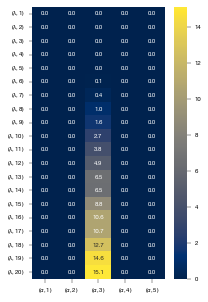

In [8]:
steps_list = range(1, 11) # 11, 21

steps_lambda = range(1, 21) # range(1, 21) # [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
steps_alpha = range(1, 6) # range(4, 8) # [3]
rows = [fr'$(\lambda, {i})$' for i in steps_lambda] # steps_list # range(1, 21)]
cols = [fr'$(\alpha, {i})$' for i in steps_alpha] # steps_list # range(1, 6)]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(3, 5)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.savefig('paper_figures/model_probs_cd44_minimal2.pdf')

In [6]:
print(net_names.index('net_1_1'))
print(net_names.index('net_3_20'))

0
59


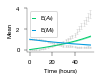

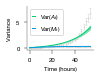

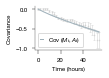

In [7]:
est = res[0]

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_mean_net_1_1.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_var_net_1_1.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov $(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_cov_net_1_1.pdf', settings=settings)

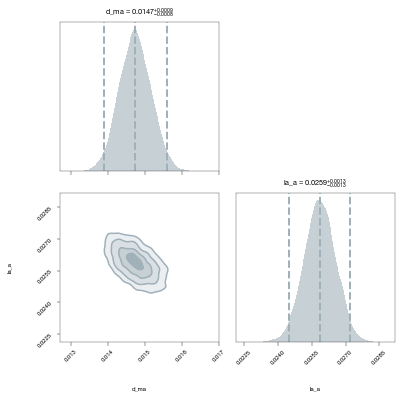

In [8]:
me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_cov_net_1_1.pdf')

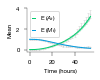

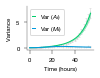

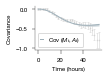

In [9]:
est = res[59]

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_mean_net_3_20.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_var_net_3_20.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_cov_net_3_20.pdf', settings=settings)

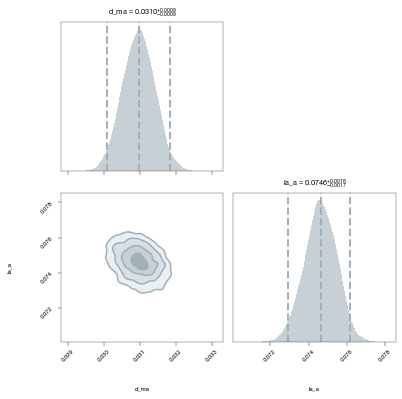

In [10]:
me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_cov_net_3_20.pdf')

###### minimal model mean-only

In [9]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_minimal2_meanfit.pickle', 'rb'))

In [10]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]

sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = np.array(log_evids)[sort_inds]

print(model_probs_sorted[:10])
print(log_evids_sorted[:10])
print(net_names_sorted[:10])

[0.06633111 0.0648332  0.06071439 0.05938814 0.05862469 0.05644647
 0.05519772 0.05375394 0.05371486 0.05364467]
[75.46725385 75.44441257 75.3787755  75.3566893  75.34375073 75.30588758
 75.2835164  75.25701171 75.25628445 75.25497702]
['net_3_15' 'net_3_16' 'net_3_17' 'net_3_14' 'net_3_19' 'net_3_12'
 'net_3_10' 'net_3_11' 'net_3_20' 'net_3_18']


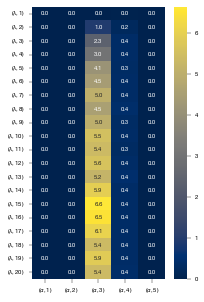

In [11]:
steps_list = range(1, 11) # 11, 21

steps_lambda = range(1, 21) # range(1, 21) # [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
steps_alpha = range(1, 6) # range(4, 8) # [3]
rows = [fr'$(\lambda, {i})$' for i in steps_lambda] # steps_list # range(1, 21)]
cols = [fr'$(\alpha, {i})$' for i in steps_alpha] # steps_list # range(1, 6)]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(3, 5)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.savefig('paper_figures/model_probs_cd44_minimal2_meanfit.pdf')

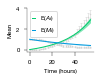

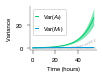

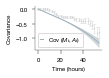

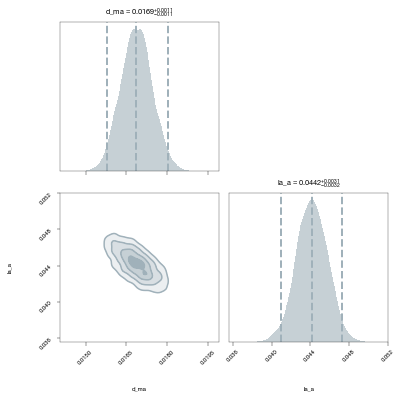

In [16]:
est = res[0]

# repair data set (due to newer memopy version)
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_mean_net_1_1_meanfit.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_var_net_1_1_meanfit.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov $(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_cov_net_1_1_meanfit.pdf', settings=settings)

me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_cov_net_1_1_meanfit.pdf')

54


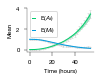

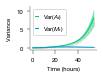

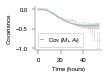

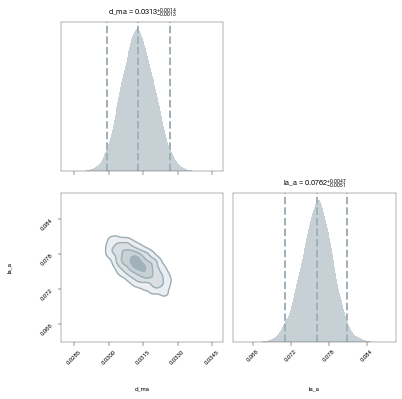

In [18]:
print(net_names.index('net_3_15')) # 54
est = res[54]

# repair data set (due to newer memopy version)
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_mean_net_3_15_meanfit.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_var_net_3_15_meanfit.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov $(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_cov_net_3_15_meanfit.pdf', settings=settings)

me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_cov_net_3_15_meanfit.pdf')

###### par2 model results

In [55]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]
print(len(res))

288


In [56]:
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = np.array(log_evids)[sort_inds]

print(model_probs_sorted[:10])
print(log_evids_sorted[:10])
print(net_names_sorted[:10])

[0.20466724 0.12799195 0.10456966 0.06935069 0.06727789 0.05171219
 0.05031148 0.04723524 0.04024633 0.03639838]
[235.37342517 234.90400709 234.70189318 234.29121587 234.26087143
 233.99773332 233.97027302 233.90717993 233.74705854 233.64656395]
['par2_d_6_8_l_18' 'par2_d_6_8_l_14' 'par2_d_6_8_l_10' 'par2_d_6_10_l_14'
 'par2_d_6_10_l_18' 'par2_d_6_10_l_10' 'par2_d_6_8_l_8' 'par2_d_6_14_l_18'
 'par2_d_6_14_l_14' 'par2_d_6_18_l_14']


In [57]:
est_i = list(model_probs).index(max(model_probs))
print(est_i, net_names[est_i])
est = res[est_i]
print(est.bay_est_log_evidence)

# repair est object due to new memopy version
est.data.data_mean_exists_only = False

183 par2_d_6_8_l_18
235.37342516505308


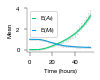

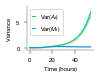

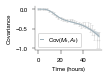

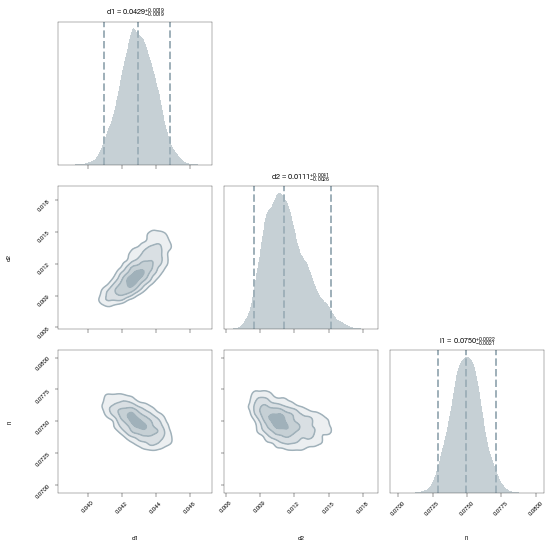

In [29]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_mean_par2_d_6_8_l_18.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_var_par2_d_6_8_l_18.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_cov_par2_d_6_8_l_18.pdf', settings=settings)

me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_par2_d_6_8_l_18.pdf')

In [58]:
# set model prior to give classes same weight
mprior = np.array([1/len(res)]*len(res))
print(sum(mprior))
print(len(mprior))

0.999999999999997
288


In [63]:
# res = [est]
celltype = 1 # 0 or 1 (active, naive)
time_point = -1 # last time point
sample_n = 100 # 1000 # posterior samples of cell histograms; typically 1000-10000
sim_n = 50 # 500 # simulation repeats per given model and theta; ideally, inf
count_max = 16
y = hist_cell_counts_samples(res, celltype, time_point, sample_n, count_max, sim_n, mprior)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[  0.   0. 100.   0.]


In [64]:
print(y.shape)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)

(16, 100)


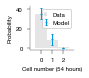

In [65]:
# compute model histogram over all models
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

linelow = 44*y_95_lower/sim_n
line = 44*y_median/sim_n
lineupp = 44*y_95_upper/sim_n
errlow = line-linelow
errupp = lineupp-line

# plt.fill_between(range(count_max), linelow, line, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100)
# plt.plot(range(count_max), line, color=cnaive, zorder=200, linewidth=1.0)
# plt.fill_between(range(count_max), line, lineupp, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100,
#                 label='Models')
cutplot = 3
plt.errorbar(list(range(count_max))[:cutplot], line[:cutplot], yerr=np.array([errlow, errupp])[:, :cutplot],
            color=cnaive, linewidth=1.0, capsize=1.0,
             zorder=100, markersize=2, fmt='.', label='Model')

plt.hist(res[0].data.data_counts[:, 1, -1], bins=np.linspace(-0.5, 9.5, num=11), 
         color='black', alpha=0.1, label='Data')
plt.xticks([0, 1, 2])
plt.xlim(None, 3)
plt.ylim(-1.5, None)
plt.xlabel('Cell number (54 hours)')
plt.ylabel('Probability')
plt.legend()
plt.savefig(f'paper_figures/hist_cd44_naive_688_par2.pdf', bbox_inches='tight') # _thin4

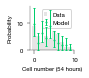

In [62]:
# compute model histogram over all models
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

linelow = 44*y_95_lower/sim_n
line = 44*y_median/sim_n
lineupp = 44*y_95_upper/sim_n
errlow = line-linelow
errupp = lineupp-line

# plt.fill_between(range(count_max), linelow, line, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100)
# plt.plot(range(count_max), line, color=cactiv, zorder=200, linewidth=1.0)
# plt.fill_between(range(count_max), line, lineupp, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100,
#                 label='Model')
cutplot = 10
plt.errorbar(list(range(count_max))[:cutplot], line[:cutplot], 
             yerr=np.array([errlow, errupp])[:, :cutplot],
            color=cactiv, linewidth=1.0, capsize=1.0,
             zorder=100, markersize=2, fmt='.', label='Model')

plt.hist(res[0].data.data_counts[:, 0, -1], bins=np.linspace(-0.5, 9.5, num=11), 
         color='black', alpha=0.1, label='Data')

plt.xlim(-1, 10)
plt.xlabel('Cell number (54 hours)')
plt.ylabel('Probability')
plt.legend()
plt.savefig(f'paper_figures/hist_cd44_active_688_par2.pdf', bbox_inches='tight') # _thin4

In [71]:
# compare best par2 and best par1+i
me.selection.compute_model_probabilities_from_log_evidences(np.array([
    235.37342517, # par2
    234.83804384, # par1+i
]))

array([0.63073734, 0.36926266])

###### par 2 mean only

In [80]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par2_meanfit.pickle', 'rb'))
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]
print(len(res))

288


In [81]:
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = np.array(log_evids)[sort_inds]

print(model_probs_sorted[:10])
print(log_evids_sorted[:10])
print(net_names_sorted[:10])

[0.09698074 0.07973021 0.06418389 0.06175942 0.05079801 0.03152467
 0.03127389 0.02623562 0.02416118 0.02296904]
[81.3567456  81.16088175 80.94398537 80.90547963 80.71009029 80.23300363
 80.22501683 80.04935138 79.96698034 79.9163802 ]
['par2_d_6_8_l_14' 'par2_d_6_8_l_18' 'par2_d_6_8_l_8' 'par2_d_6_8_l_10'
 'par2_d_6_8_l_6' 'par2_d_6_10_l_14' 'par2_d_6_10_l_18' 'par2_d_6_6_l_18'
 'par2_d_6_6_l_10' 'par2_d_6_8_l_4']


In [82]:
est_i = list(model_probs).index(max(model_probs))
print(est_i, net_names[est_i])
est = res[est_i]
print(est.bay_est_log_evidence)

# repair est object due to new memopy version
est.data.data_mean_exists_only = False

182 par2_d_6_8_l_14
81.3567456045947


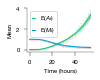

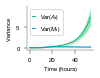

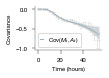

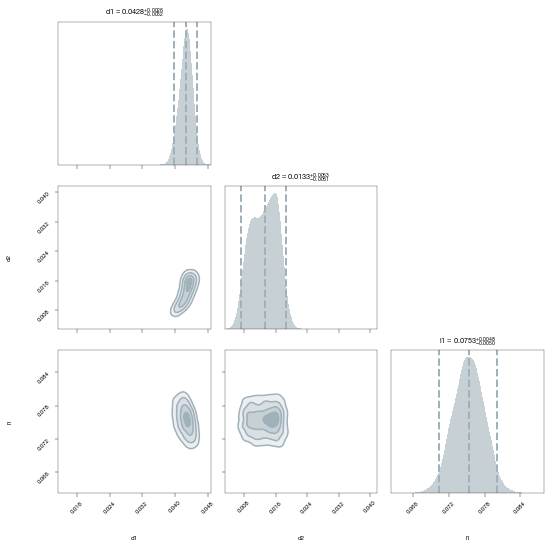

In [75]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_mean_par2_d_6_8_l_14_meanfit.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_var_par2_d_6_8_l_14_meanfit.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_cov_par2_d_6_8_l_14_meanfit.pdf', settings=settings)

me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_par2_d_6_8_l_14_meanfit.pdf')

In [76]:
# compare to best minimal model (mean only fit)
me.selection.compute_model_probabilities_from_log_evidences(np.array([
    75.46725385, # net_3_15
    81.3567456045947, # par2_d_6_8_l_14
]))

array([0.00276074, 0.99723926])

In [83]:
data = res[0].data
mprior = np.array([1/len(res)]*len(res))
print(len(mprior))
print(np.sum(mprior))

288
1.0000000000000002


In [84]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = True # True or False
time_max = 60.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

y = waiting_time_distr_samples_act(x, res, samples, time_max, mprior)

[    0.     0. 20000.     0.]


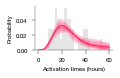

In [85]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.4, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')


plt.fill_between(x, y_997_lower, y_95_lower, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='lightseagreen', lw=2, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='lightseagreen', lw=2, alpha=0.6)
plt.plot(x, y_median, color=cwact, lw=1, zorder=200)
# plt.plot(x, y_hdi_68_upper, color='lightseagreen', lw=2, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='lightseagreen', lw=2, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('paper_figures/waiting_times_act_par2_meanfit.pdf', bbox_inches='tight') # pdf, png

In [86]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = False # True or False
time_max = 60.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

# NOTE: the data we plot here is only from first divisions! (so its not the complete data, 
# which is inaccessible from the data)

y = waiting_time_distr_samples_div(x, res, samples, time_max, mprior)

[    0.     0. 20000.     0.]


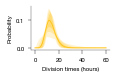

In [87]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.4, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_count_increase_after_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')
    
plt.fill_between(x, y_997_lower, y_95_lower, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='darkorange', lw=0.5, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='blue', lw=0.5, alpha=0.6)
plt.plot(x, y_median, color=cwdiv, lw=1, zorder=200)
# plt.plot(x, y_hdi_68_upper, color='darkorange', lw=0.5, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='darkorange', lw=0.5, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('paper_figures/waiting_times_div_par2_meanfit.pdf', bbox_inches='tight') # pdf, png

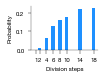

In [89]:
samples = 10000
div_steps = list()

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    div_steps.append(est.net.net_modules[2]['module_steps'])
    
    if not est.net.net_modules[2]['sym_rate']=='l1':
        print('error')

plt.hist(np.array(div_steps), bins=np.linspace(1, 19, endpoint=True, num=19)-0.5, 
         density=True, color='dodgerblue')
plt.xticks([1, 2, 4, 6, 8, 10, 14, 18])
plt.ylabel('Probability')
plt.xlabel('Division steps')
# plt.savefig('waiting_times_div_steps.pdf')
plt.show()

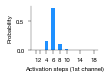

In [96]:
samples = 50000
alpha_steps = list()

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    alpha_steps.append(est.net.net_modules[0]['module_steps'])
    
    if not est.net.net_modules[0]['sym_rate']=='d1':
        print('error')

plt.hist(np.array(alpha_steps), bins=np.linspace(1, 19, endpoint=True, num=19)-0.5, 
         density=True, color='dodgerblue')
plt.xticks([1, 2, 4, 6, 8, 10, 14, 18])
plt.ylabel('Probability')
plt.xlabel('Activation steps (1st channel)')
# plt.savefig('waiting_times_act_steps.pdf')
plt.show()

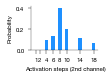

In [98]:
samples = 50000
alpha_steps = list()

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    alpha_steps.append(est.net.net_modules[1]['module_steps'])
    
    if not est.net.net_modules[1]['sym_rate']=='d2':
        print('error')

plt.hist(np.array(alpha_steps), bins=np.linspace(1, 19, endpoint=True, num=19)-0.5, 
         density=True, color='dodgerblue')
plt.xticks([1, 2, 4, 6, 8, 10, 14, 18])
plt.ylabel('Probability')
plt.xlabel('Activation steps (2nd channel)')
# plt.savefig('waiting_times_act_steps.pdf')
plt.show()

###### par1+i results

In [67]:
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_sigma022_par1+i.pickle', 'rb'))
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]

In [68]:
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = np.array(log_evids)[sort_inds]

print(model_probs_sorted[:10])
print(log_evids_sorted[:10])
print(net_names_sorted[:10])

[0.3533542  0.25585811 0.22070271 0.11522469 0.04477144 0.00233376
 0.00177736 0.00168872 0.00157189 0.00150213]
[234.83804384 234.51519592 234.36738946 233.71745691 232.77214335
 229.81805518 229.54569958 229.49454366 229.42285088 229.37745537]
['net_6_18' 'net_6_14' 'net_6_10' 'net_6_8' 'net_6_6' 'net_8_10' 'net_8_8'
 'net_8_14' 'net_8_18' 'net_6_4']


In [73]:
est_i = list(model_probs).index(max(model_probs))
print(est_i, net_names[est_i])
est = res[est_i]
est.bay_est_log_evidence

# repair data object (data object is from older memopy version)
est.data.data_mean_exists_only = False

31 net_6_18


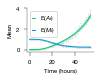

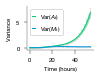

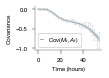

In [42]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_mean_par1+1_net_6_18.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_var_par1+1_net_6_18.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_cov_par1+1_net_6_18.pdf', settings=settings)

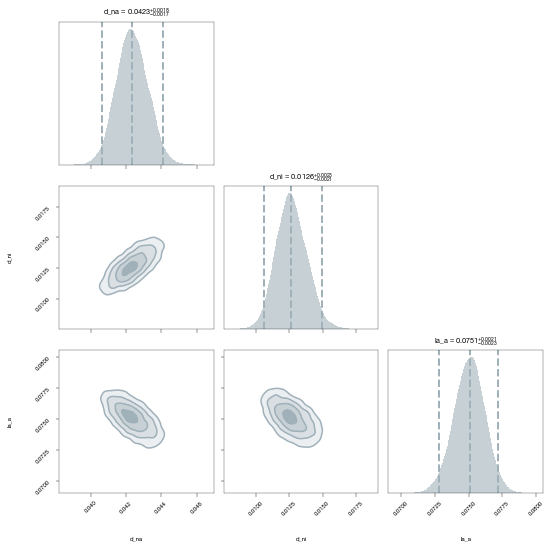

In [43]:
me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_par1+1_net_6_18.pdf')

In [50]:
# compute model probs of best models
# markov, best erlang, par1+i, par2, par3
levids_best_of = np.array([-238.59155040972584, 209.00325377, 234.83804384, 236.3921228756776, 235.88771465])
print(me.selection.compute_model_probabilities_from_log_evidences(levids_best_of))
print(me.selection.compute_model_bayes_factors_from_log_evidences(levids_best_of))

[2.87260572e-207 7.01826244e-013 1.16449163e-001 5.50889281e-001
 3.32661555e-001]
[1.91773371e+206 7.84936850e+011 4.73072769e+000 1.00000000e+000
 1.65600525e+000]


In [81]:
est.bay_est_params_median

array([0.04232   , 0.01262042, 0.07507427])

In [61]:
est.bay_est_log_evidence
est.bay_est_params_median
est.net.net_modules
est.net.net_theta_symbolic

['theta_0', 'theta_1', 'theta_2']

In [13]:
data = res[0].data
mprior = np.array([1/len(res)]*len(res))
print(len(mprior))
print(np.sum(mprior))

64
1.0


In [11]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = True # True or False
time_max = 60.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

y = waiting_time_distr_samples_act(x, res, samples, time_max, mprior)

[    0. 20000.     0.     0.]


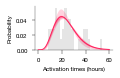

In [14]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.4, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')


plt.fill_between(x, y_997_lower, y_95_lower, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='lightseagreen', lw=2, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='lightseagreen', lw=2, alpha=0.6)
plt.plot(x, y_median, color=cwact, lw=1, zorder=200)
# plt.plot(x, y_hdi_68_upper, color='lightseagreen', lw=2, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='lightseagreen', lw=2, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('paper_figures/waiting_times_act_par1+i.pdf', bbox_inches='tight') # pdf, png

In [15]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = False # True or False
time_max = 60.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

# NOTE: the data we plot here is only from first divisions! (so its not the complete data, 
# which is inaccessible from the data)

y = waiting_time_distr_samples_div(x, res, samples, time_max, mprior)

[    0. 20000.     0.     0.]


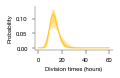

In [16]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.4, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_count_increase_after_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')
    
plt.fill_between(x, y_997_lower, y_95_lower, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='darkorange', lw=0.5, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='blue', lw=0.5, alpha=0.6)
plt.plot(x, y_median, color=cwdiv, lw=1, zorder=200)
# plt.plot(x, y_hdi_68_upper, color='darkorange', lw=0.5, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='darkorange', lw=0.5, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('paper_figures/waiting_times_div.pdf', bbox_inches='tight') # pdf, png

In [74]:
# set model prior to give classes same weight
mprior = np.array([1/len(res)]*len(res))
print(sum(mprior))
print(len(mprior))

1.0
64


In [79]:
# res = [est]
celltype = 0 # 0 or 1 (active, naive)
time_point = -1 # last time point
sample_n = 100 # 1000 # posterior samples of cell histograms; typically 1000-10000
sim_n = 50 # 500 # simulation repeats per given model and theta; ideally, inf
count_max = 16
y = hist_cell_counts_samples(res, celltype, time_point, sample_n, count_max, sim_n, mprior)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[  0. 100.   0.   0.]


In [80]:
print(y.shape)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)

(16, 100)


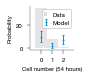

In [81]:
# compute model histogram over all models
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

linelow = 44*y_95_lower/sim_n
line = 44*y_median/sim_n
lineupp = 44*y_95_upper/sim_n
errlow = line-linelow
errupp = lineupp-line

# plt.fill_between(range(count_max), linelow, line, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100)
# plt.plot(range(count_max), line, color=cnaive, zorder=200, linewidth=1.0)
# plt.fill_between(range(count_max), line, lineupp, color=cnaive, alpha=0.2, linewidth=0.0, zorder=100,
#                 label='Models')
cutplot = 3
plt.errorbar(list(range(count_max))[:cutplot], line[:cutplot], yerr=np.array([errlow, errupp])[:, :cutplot],
            color=cnaive, linewidth=1.0, capsize=1.0,
             zorder=100, markersize=2, fmt='.', label='Model')

plt.hist(res[0].data.data_counts[:, 1, -1], bins=np.linspace(-0.5, 9.5, num=11), 
         color='black', alpha=0.1, label='Data')
plt.xticks([0, 1, 2])
plt.xlim(None, 3)
plt.ylim(-1.5, None)
plt.xlabel('Cell number (54 hours)')
plt.ylabel('Probability')
plt.legend()
plt.savefig(f'paper_figures/hist_cd44_naive_688_par1+i.pdf', bbox_inches='tight') # _thin4

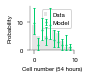

In [82]:
# compute model histogram over all models
plt.rcParams.update({'figure.figsize': (0.8, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

linelow = 44*y_95_lower/sim_n
line = 44*y_median/sim_n
lineupp = 44*y_95_upper/sim_n
errlow = line-linelow
errupp = lineupp-line

# plt.fill_between(range(count_max), linelow, line, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100)
# plt.plot(range(count_max), line, color=cactiv, zorder=200, linewidth=1.0)
# plt.fill_between(range(count_max), line, lineupp, color=cactiv, alpha=0.2, linewidth=0.0, zorder=100,
#                 label='Model')
cutplot = 10
plt.errorbar(list(range(count_max))[:cutplot], line[:cutplot], 
             yerr=np.array([errlow, errupp])[:, :cutplot],
            color=cactiv, linewidth=1.0, capsize=1.0,
             zorder=100, markersize=2, fmt='.', label='Model')

plt.hist(res[0].data.data_counts[:, 0, -1], bins=np.linspace(-0.5, 9.5, num=11), 
         color='black', alpha=0.1, label='Data')

plt.xlim(-1, 10)
plt.xlabel('Cell number (54 hours)')
plt.ylabel('Probability')
plt.legend()
plt.savefig(f'paper_figures/hist_cd44_active_688_par1+i.pdf', bbox_inches='tight') # _thin4

In [88]:
import itertools
steps_list = [1, 2, 4, 6, 8, 10, 14, 18] # [2, 4, 6, 8, 10, 14, 18]
sparse_steps_list = list(itertools.combinations_with_replacement(steps_list, 2))
for d1, d2 in sparse_steps_list:
    pass
d1, d2

(18, 18)

###### par3 model results

In [20]:
res = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]

In [21]:
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = np.array(log_evids)[sort_inds]

print(model_probs_sorted[:10])
print(log_evids_sorted[:10])
print(net_names_sorted[:10])

[0.0278788  0.02550369 0.02247498 0.02124972 0.02028658 0.02023628
 0.01975946 0.01950185 0.01909961 0.01891333]
[235.88771465 235.79867124 235.67225071 235.61619157 235.56980755
 235.5673253  235.54348052 235.53035758 235.5095162  235.49971511]
['net_alphaF6_alphaS6_alphaT6_lambda14'
 'net_alphaF6_alphaS6_alphaT6_lambda18'
 'net_alphaF8_alphaS8_alphaT18_lambda14'
 'net_alphaF4_alphaS6_alphaT6_lambda18'
 'net_alphaF8_alphaS8_alphaT18_lambda18'
 'net_alphaF6_alphaS6_alphaT14_lambda14'
 'net_alphaF6_alphaS6_alphaT18_lambda18'
 'net_alphaF6_alphaS6_alphaT6_lambda10'
 'net_alphaF6_alphaS8_alphaT14_lambda14'
 'net_alphaF6_alphaS6_alphaT14_lambda18']


In [22]:
est_i = list(model_probs).index(max(model_probs))
print(est_i, net_names[est_i])
est = res[est_i]
est.bay_est_log_evidence

348 net_alphaF6_alphaS6_alphaT6_lambda14


235.88771464915

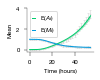

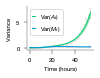

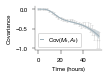

In [14]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_mean_net_alphaF6_alphaS6_alphaT6_lambda14.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_var_net_alphaF6_alphaS6_alphaT6_lambda14.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_cov_net_alphaF6_alphaS6_alphaT6_lambda14.pdf', settings=settings)

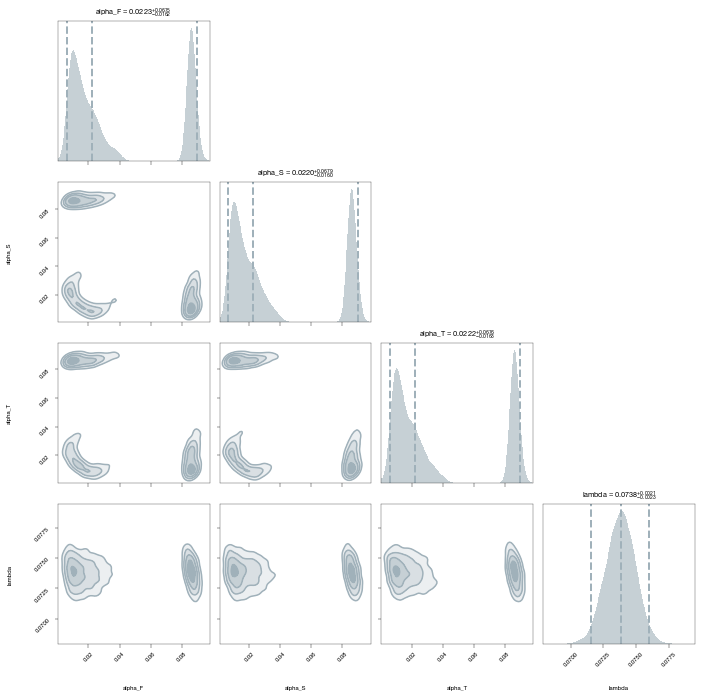

In [15]:
me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_cov_net_alphaF6_alphaS6_alphaT6_lambda14.pdf')

###### summary plots

In [38]:
res1 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))
res2 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))
res3 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

100 196 588 884


In [47]:
net_names = [est.net.net_name for est in res]
mprior = np.array([0.25] + [0.25/99]*99 + [0.25/196]*196 + [0.25/588]*588)
print(sum(mprior))
model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)
print(len(model_probs))

1.0000000000000184
884


In [48]:
print(len(model_probs[0:1]))
print(len(model_probs[1:100]))
print(len(model_probs[100:296]))
print(len(model_probs[296:]))

1
99
196
588


7.596532311474325e-206
1.0259578356828017e-12
0.4633507131137356
0.5366492868852237


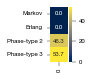

In [49]:
print(sum(model_probs[0:1]))
print(sum(model_probs[1:100]))
print(sum(model_probs[100:296]))
print(sum(model_probs[296:]))

plt.figure(figsize=(0.4,1))
df = pd.DataFrame(np.array([model_probs[0], sum(model_probs[1:100]), sum(model_probs[100:296]), sum(model_probs[296:])]) * 100.0, index=['Markov', 'Erlang', 'Phase-type 2', 'Phase-type 3']) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/models_probs_map.pdf', bbox_inches='tight')

59
104
348
59
104
348
204
3.2512059285219294e-207
7.943246862012952e-13
0.6234947201904378
0.3765052798087817


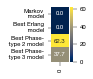

In [53]:
res1_probs = me.selection.compute_model_probabilities(res1)
res2_probs = me.selection.compute_model_probabilities(res2)
res3_probs = me.selection.compute_model_probabilities(res3)
print(list(res1_probs).index(max(res1_probs)))
print(list(res2_probs).index(max(res2_probs)))
print(list(res3_probs).index(max(res3_probs)))
print(list(model_probs[0:100]).index(max(model_probs[0:100])))
print(list(model_probs[100:296]).index(max(model_probs[100:296])))
print(list(model_probs[296:]).index(max(model_probs[296:])))
print(list(model_probs).index(max(model_probs)))

bestof_probs = me.selection.compute_model_probabilities([
                res[0], res[59], res[104+100], res[348+100+196]])

print(bestof_probs[0])
print(bestof_probs[1])
print(bestof_probs[2])
print(bestof_probs[3])

plt.figure(figsize=(0.4,1))
df = pd.DataFrame(np.array([bestof_probs[0], bestof_probs[1], bestof_probs[2], bestof_probs[3]]) * 100.0, index=['Markov\n model', 'Best Erlang\n model', 'Best Phase-\n type 2 model', 'Best Phase-\n type 3 model']) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/models_probs_map_bestof.pdf', bbox_inches='tight')

86
798
(884,)


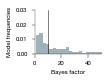

In [56]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
bf = me.selection.compute_model_bayes_factors(res)
bf[bf > 100.0] = 100.0
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlim((0, 50)) # 110
plt.ylim((None, 0.03))
plt.hist(bf, density=True, color=grey, bins=40)
plt.axvline(x=10.0, lw=0.5, color='black')
plt.xlabel('Bayes factor')
plt.ylabel('Model frequencies')
plt.savefig('paper_figures/bfs_cd44_full.pdf', bbox_inches='tight')

print(np.sum(bf < 10.0))
print(np.sum(bf >= 10.0))
print(bf.shape)

884
True


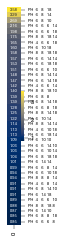

In [57]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
print(len(model_probs))

ntop = 40

sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

# check if all ntop models are phase type
is_ph = True
for name in net_names_sorted[0:ntop]:
    if 'alphaF' in name:
        pass
    else:
        is_ph = False
print(is_ph)
    
def process_net_names(net_names):
    net_names_style = list()
    for name in net_names:
        name_style = str(name[4:])
        name_style = name_style.replace('_', r', ')
        name_style = name_style.replace('alphaF', r'$n_{\alpha_1}$=')
        name_style = name_style.replace('alphaS', r'$n_{\alpha_2}$=')
        name_style = name_style.replace('alphaT', r'$n_{\alpha_3}$=')
        name_style = name_style.replace('lambda', r'$n_{\lambda}$=')
        net_names_style.append(name_style)
    return net_names_style

def process_net_names_simple(net_names):
    net_names_style = list()
    for name in net_names:
        name_style = str(name[4:])
        name_style = name_style.replace('_', ' ')
        name_style = name_style.replace('alphaF1', '1')
        name_style = name_style.replace('alphaF2', '2  ')
        name_style = name_style.replace('alphaF4', '4  ')
        name_style = name_style.replace('alphaF6', '6  ')
        name_style = name_style.replace('alphaF8', '8  ')
        
        name_style = name_style.replace('alphaS1', '1')
        name_style = name_style.replace('alphaS2', '2  ')
        name_style = name_style.replace('alphaS4', '4  ')
        name_style = name_style.replace('alphaS6', '6  ')
        name_style = name_style.replace('alphaS8', '8  ')
        
        name_style = name_style.replace('alphaT1', '1')
        name_style = name_style.replace('alphaT2', '2  ')
        name_style = name_style.replace('alphaT4', '4  ')
        name_style = name_style.replace('alphaT6', '6  ')
        name_style = name_style.replace('alphaT8', '8  ')
        
        name_style = name_style.replace('lambda1', '1')
        name_style = name_style.replace('lambda2', '2')
        name_style = name_style.replace('lambda4', '4')
        name_style = name_style.replace('lambda6', '6')
        name_style = name_style.replace('lambda8', '8')
        name_style = 'PH  ' + name_style
        net_names_style.append(name_style)
    return net_names_style

plt.rcParams.update({'mathtext.default':  'regular' })
plt.figure(figsize=(0.3,4.0))
df = pd.DataFrame(np.array([model_probs_sorted[:ntop]]).T * 100.0, index=process_net_names_simple(net_names_sorted[:ntop])) # , index=rows
g = sns.heatmap(df, cmap='cividis', annot=True, fmt='.2f', annot_kws={"size":4}, yticklabels=True) # annot=True
ax = plt.gca()
ax.tick_params(right=True, left=False, labelright=True, labelleft=False)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 4)
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/models_probs_map_single.pdf', bbox_inches='tight')

In [58]:
len(model_probs_sorted[:40])

40

###### waiting times

In [17]:
res1 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))
res2 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))
res3 = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
data = res[0].data
print(sum(['alphaF' in name for name in net_names]))

100 196 588 884
784


In [18]:
# set model prior to give classes same weight
mprior = np.array([0.25] + [0.25/99]*99 + [0.25/196]*196 + [0.25/588]*588)
print(sum(mprior))
print(len(mprior))

1.0000000000000184
884


In [19]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = True # True or False
time_max = 60.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

y = waiting_time_distr_samples_act(x, res, samples, time_max, mprior)

[    0.     0.  9225. 10775.]


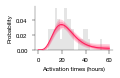

In [20]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.4, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')


plt.fill_between(x, y_997_lower, y_95_lower, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='lightseagreen', lw=2, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='lightseagreen', lw=2, alpha=0.6)
plt.plot(x, y_median, color=cwact, lw=1, zorder=200)
# plt.plot(x, y_hdi_68_upper, color='lightseagreen', lw=2, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='lightseagreen', lw=2, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('paper_figures/waiting_times_act.pdf', bbox_inches='tight') # pdf, png

In [21]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = False # True or False
time_max = 60.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

# NOTE: the data we plot here is only from first divisions! (so its not the complete data, 
# which is inaccessible from the data)

y = waiting_time_distr_samples_div(x, res, samples, time_max, mprior)

[    0.     0.  9276. 10724.]


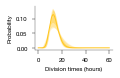

In [22]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.4, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_count_increase_after_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')
    
plt.fill_between(x, y_997_lower, y_95_lower, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='darkorange', lw=0.5, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='blue', lw=0.5, alpha=0.6)
plt.plot(x, y_median, color=cwdiv, lw=1, zorder=200)
# plt.plot(x, y_hdi_68_upper, color='darkorange', lw=0.5, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='darkorange', lw=0.5, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('paper_figures/waiting_times_div.pdf', bbox_inches='tight') # pdf, png

##### Figure 4 <a id='figure4'></a> [↑](#top)

###### thin data

In [69]:
res1 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_minimal2.pickle', 'rb'))
res2 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par2.pickle', 'rb'))
res3 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

100 196 588 884


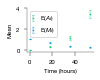

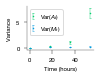

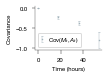

In [48]:
data = res[0].data
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.data_mean_plot(data, x_label='Time (hours)', save='paper_figures/data_cd44_thin4_mean.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.data_variance_plot(data, x_label='Time (hours)', save='paper_figures/data_cd44_thin4_var.pdf', settings=settings)

settings = {
    ('M_t', 'A_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.data_covariance_plot(data, x_label='Time (hours)', save='paper_figures/data_cd44_thin4_cov.pdf', settings=settings)

In [72]:
net_names = [est.net.net_name for est in res]
mprior = np.array([0.25] + [0.25/99]*99 + [0.25/196]*196 + [0.25/588]*588)
print(sum(mprior))
model_probs = me.selection.compute_model_probabilities(res, mprior=mprior)

1.0000000000000184


3.8294626656513344e-12
0.04214570337710405
0.3754489980568839
0.5824052985621854


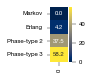

In [73]:
print(sum(model_probs[0:1]))
print(sum(model_probs[1:100]))
print(sum(model_probs[100:296]))
print(sum(model_probs[296:]))

plt.figure(figsize=(0.4,1))
df = pd.DataFrame(np.array([sum(model_probs[0:1]), sum(model_probs[1:100]), sum(model_probs[100:296]), sum(model_probs[296:])]) * 100.0, index=['Markov', 'Erlang', 'Phase-type 2', 'Phase-type 3']) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/models_probs_map_thin4.pdf', bbox_inches='tight')

39
111
370
39
111
211
net_2_20 net_alphaF2_alphaS10_alphaT18_lambda18
7.165654144993785e-13
0.0645644110889026
0.49788331987744333
0.4375522690329393


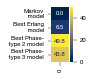

In [75]:
res1_probs = me.selection.compute_model_probabilities(res1)
res2_probs = me.selection.compute_model_probabilities(res2)
res3_probs = me.selection.compute_model_probabilities(res3)
print(list(res1_probs).index(max(res1_probs)))
print(list(res2_probs).index(max(res2_probs)))
print(list(res3_probs).index(max(res3_probs)))

print(list(model_probs[0:100]).index(max(model_probs[0:100])))
print(list(model_probs[100:296]).index(max(model_probs[100:296])))
print(list(model_probs).index(max(model_probs)))

bestof_probs = me.selection.compute_model_probabilities([
                    res[0], res[39], res[211], res[100+196+370]])
print(net_names[39], net_names[470])
print(bestof_probs[0])
print(bestof_probs[1])
print(bestof_probs[2])
print(bestof_probs[3])

plt.figure(figsize=(0.4,1))
df = pd.DataFrame(np.array([bestof_probs[0], bestof_probs[1], bestof_probs[2], bestof_probs[3]]) * 100.0, index=['Markov\n model', 'Best Erlang\n model', 'Best Phase-\n type 2 model', 'Best Phase-\n type 3 model']) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/models_probs_map_thin4_bestof.pdf', bbox_inches='tight')

In [77]:
print(res1[0].bay_est_log_evidence)
print(max([est.bay_est_log_evidence for est in res1]))
print(max([est.bay_est_log_evidence for est in res2]))
print(max([est.bay_est_log_evidence for est in res3]))
me.selection.compute_model_probabilities_from_log_evidences(
    np.array([14.997059839504479,
                40.22127476209889,
                42.26397716719244,
                42.13480758579131]))

14.997059839504479
40.22127476209889
42.26397716719244
42.13480758579131


array([7.16565414e-13, 6.45644111e-02, 4.97883320e-01, 4.37552269e-01])

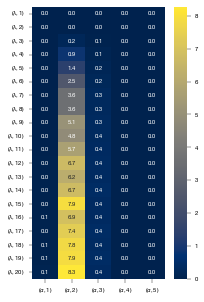

In [53]:
res = pickle.load(open('estimation_count_data_cd44_filtered_thin4_minimal2.pickle', 'rb'))

net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)

steps_list = range(1, 11) # 11, 21

steps_lambda = range(1, 21) # range(1, 21) # [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
steps_alpha = range(1, 6) # range(4, 8) # [3]
rows = [fr'$(\lambda, {i})$' for i in steps_lambda] # steps_list # range(1, 21)]
cols = [fr'$(\alpha, {i})$' for i in steps_alpha] # steps_list # range(1, 6)]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_{steps_alpha[j]}_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(3, 5)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.savefig('paper_figures/model_probs_cd44_thin4_minimal2.pdf')

In [23]:
res1 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_minimal2.pickle', 'rb'))
res2 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par2.pickle', 'rb'))
res3 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
data = res[0].data

100 196 588 884


In [24]:
# set model prior to give classes same weight
mprior = np.array([0.25] + [0.25/99]*99 + [0.25/196]*196 + [0.25/588]*588)
print(sum(mprior))
print(len(mprior))

1.0000000000000184
884


In [25]:
print(net_names[list(model_probs).index(max(model_probs))])

net_alphaF6_alphaS10_lambda18


In [26]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = True # True or False
time_max = 60.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

y = waiting_time_distr_samples_act(x, res, samples, time_max, mprior)

[  824.     0.  7690. 11486.]


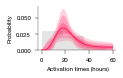

In [27]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.4, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')


plt.fill_between(x, y_997_lower, y_95_lower, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwact, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwact, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwact, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='lightseagreen', lw=2, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='lightseagreen', lw=2, alpha=0.6)
plt.plot(x, y_median, color=cwact, lw=1, zorder=200)
# plt.plot(x, y_hdi_68_upper, color='lightseagreen', lw=2, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='lightseagreen', lw=2, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('paper_figures/waiting_times_thin4_act.pdf', bbox_inches='tight') # pdf, png

In [28]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = False # True or False
time_max = 60.0 # 150.0, 54.0
x = np.linspace(0.0, time_max, num=200)

# NOTE: the data we plot here is only from first divisions! (so its not the complete data, 
# which is inaccessible from the data)

y = waiting_time_distr_samples_div(x, res, samples, time_max, mprior)

[  862.     0.  7479. 11659.]


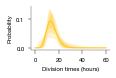

In [29]:
y_997_lower = np.percentile(y, 0.15, axis=1)
y_95_lower = np.percentile(y, 2.5, axis=1)
y_68_lower = np.percentile(y, 16.0, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_68_upper = np.percentile(y, 84.0, axis=1)
y_95_upper = np.percentile(y, 97.5, axis=1)
y_997_upper = np.percentile(y, 99.85, axis=1)

plt.rcParams.update({'figure.figsize': (1.4, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_count_increase_after_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')
    
plt.fill_between(x, y_997_lower, y_95_lower, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_lower, y_68_lower, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_lower, y_median, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)

plt.fill_between(x, y_median, y_68_upper, color=cwdiv, alpha=0.6, linewidth=0.0, zorder=100)
plt.fill_between(x, y_68_upper, y_95_upper, color=cwdiv, alpha=0.4, linewidth=0.0, zorder=100)
plt.fill_between(x, y_95_upper, y_997_upper, color=cwdiv, alpha=0.2, linewidth=0.0, zorder=100)

# plt.plot(x, y_hdi_997_lower, color='darkorange', lw=0.5, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='blue', lw=0.5, alpha=0.6)
plt.plot(x, y_median, color=cwdiv, lw=1, zorder=200)
# plt.plot(x, y_hdi_68_upper, color='darkorange', lw=0.5, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='darkorange', lw=0.5, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('paper_figures/waiting_times_thin4_div.pdf', bbox_inches='tight') # pdf, png

In [102]:
# best model plot
# (this was 'net_alphaF6_alphaS6_alphaT14_lambda18' previously in par3)
res = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par2.pickle', 'rb'))
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
list(model_probs).index(max(model_probs))

111

In [94]:
print(net_names[111])
est = res[111]

# repair est from previous memopy version
est.net_simulation_credible_band_exists = False
est.data.data_mean_exists_only = False

net_alphaF6_alphaS10_lambda18


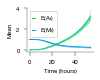

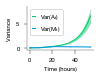

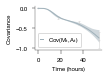

In [95]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_thin4_mean_net_alphaF6_alphaS10_lambda18.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_thin4_var_net_alphaF6_alphaS10_lambda18.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov$(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', save='paper_figures/fit_cd44_thin4_cov_net_alphaF6_alphaS10_lambda18.pdf', settings=settings)

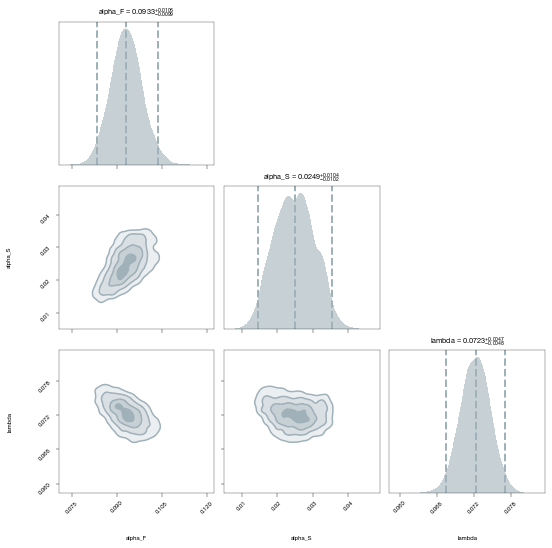

In [96]:
me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_net_alphaF6_alphaS10_lambda18.pdf')

100 196 588 884
438
446
(884,)


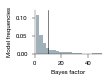

In [97]:
res1 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_minimal2.pickle', 'rb'))
res2 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par2.pickle', 'rb'))
res3 = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par3.pickle', 'rb'))
res = res1 + res2 + res3
print(len(res1), len(res2), len(res3), len(res))

net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
bf = me.selection.compute_model_bayes_factors(res)
bf[bf > 100.0] = 100.0
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlim((0, 50)) # 110
plt.hist(bf, bins=40, density=True, color=grey)
plt.axvline(x=10.0, lw=0.5, color='black')
plt.xlabel('Bayes factor')
plt.ylabel('Model frequencies')
plt.savefig('paper_figures/bfs_cd44_thin4.pdf', bbox_inches='tight')

print(np.sum(bf < 10.0))
print(np.sum(bf >= 10.0))
print(bf.shape)

In [63]:
# just a check
# bf = me.selection.compute_model_bayes_factors(res)
# inds = bf.argsort()
# net_names_sorted = np.array(net_names)[inds]

# net_names_sorted[0:370]

In [10]:
res1a = pickle.load(open('estimation_count_data_cd44_filtered_thin4_minimal2.pickle', 'rb'))
res1b = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par2.pickle', 'rb'))
res1c = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par3.pickle', 'rb'))
res1 = res1a + res1b + res1c

res2a = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_minimal2.pickle', 'rb'))
res2b = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par2.pickle', 'rb'))
res2c = pickle.load(open('estimation_count_data_cd44_filtered_sigma022_par3.pickle', 'rb'))
res2 = res2a + res2b + res2c

print([est.net.net_name for est in res1] == [est.net.net_name for est in res2])
model_logevids_thin4 = [est.bay_est_log_evidence for est in res1]
model_logevids_full = [est.bay_est_log_evidence for est in res2]

print(stats.spearmanr(model_logevids_full, model_logevids_thin4))
print(stats.pearsonr(model_logevids_full, model_logevids_thin4))

True
SpearmanrResult(correlation=0.8272359852231786, pvalue=4.78148611759715e-223)
(0.5317701150054783, 1.1091023685500042e-65)


0.5317701150054782

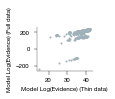

In [8]:
plt.rcParams.update({'figure.figsize': (1.0, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.scatter(model_logevids_thin4, model_logevids_full, color=grey, s=1.0)
plt.xlabel('Model Log(Evidence) (Thin data)')
plt.ylabel('Model Log(Evidence) (Full data)')
plt.xlim((None, None))
plt.ylim((None, None))
# plt.axis('square')
plt.savefig('paper_figures/evidence_corr_thin_vs_full_data.pdf', bbox_inches='tight')

np.corrcoef(model_logevids_thin4, model_logevids_full)[0, 1]

True


0.8272359852231786

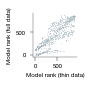

In [9]:
net_names = [est.net.net_name for est in res1]
print(net_names == [est.net.net_name for est in res2])

model_rank_thin4 = np.array(list(range(0, len(res1))))
model_rank_full = np.array(list(range(0, len(res2))))

inds = np.array(model_logevids_thin4).argsort()
model_rank_thin4_sorted = model_rank_thin4[inds]

inds = np.array(model_logevids_full).argsort()
model_rank_full_sorted = model_rank_full[inds]

x_rank = list(range(0, len(res1)))
y_rank = list()
for x in x_rank:
    ind_thin4 = model_rank_thin4_sorted[x]
    y_rank.append(list(model_rank_full_sorted).index(ind_thin4))
    
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.scatter(x_rank, y_rank, color=grey, alpha=0.5, s=1.0, lw=0.0) # , s=1.0)
plt.xlabel('Model rank (thin data)')
plt.ylabel('Model rank (full data)')
plt.xlim((None, None))
plt.ylim((None, None))
plt.axis('square')
plt.savefig('paper_figures/rank_corr_thin_vs_full_data.pdf', bbox_inches='tight')

np.corrcoef(x_rank, y_rank)[0, 1]

###### minimal model (new version and mean only)

In [119]:
# res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_thin4_minimal2.pickle', 'rb'))
res = pickle.load(open('waiting_times_files/estimation_count_data_cd44_filtered_thin4_minimal2_meanfit.pickle', 'rb'))

In [120]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
log_evids = [est.bay_est_log_evidence for est in res]

sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]
log_evids_sorted = np.array(log_evids)[sort_inds]

print(model_probs_sorted[:10])
print(log_evids_sorted[:10])
print(net_names_sorted[:10])

[0.04514801 0.04265994 0.04261217 0.04231045 0.04159293 0.04141503
 0.03717143 0.03576711 0.03563724 0.03481212]
[13.4745652  13.41787943 13.41675902 13.40965329 13.39254919 13.38826298
 13.28015946 13.24164793 13.23801018 13.21458459]
['min_d_2_l_18' 'min_d_2_l_17' 'min_d_2_l_12' 'min_d_2_l_15'
 'min_d_2_l_14' 'min_d_2_l_20' 'min_d_2_l_9' 'min_d_2_l_16' 'min_d_2_l_7'
 'min_d_2_l_19']


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text major ticklabel objects>)

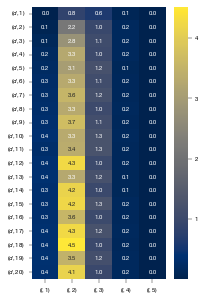

In [121]:
steps_list = range(1, 11) # 11, 21

steps_lambda = range(1, 21) # range(1, 21) # [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
steps_alpha = range(1, 6) # range(4, 8) # [3]
rows = [fr'$(d, {i})$' for i in steps_lambda] # steps_list # range(1, 21)]
cols = [fr'$(l, {i})$' for i in steps_alpha] # steps_list # range(1, 6)]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'min_d_{steps_alpha[j]}_l_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(3, 5)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
# plt.savefig('paper_figures/model_probs_cd44_minimal2_meanfit.pdf')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text major ticklabel objects>)

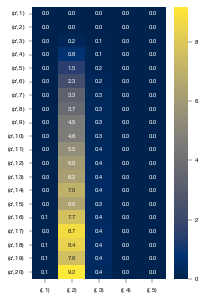

In [114]:
steps_list = range(1, 11) # 11, 21

steps_lambda = range(1, 21) # range(1, 21) # [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
steps_alpha = range(1, 6) # range(4, 8) # [3]
rows = [fr'$(d, {i})$' for i in steps_lambda] # steps_list # range(1, 21)]
cols = [fr'$(l, {i})$' for i in steps_alpha] # steps_list # range(1, 6)]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'min_d_{steps_alpha[j]}_l_{steps_lambda[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(3, 5)) # 8, 4 or 6, 8
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
# plt.savefig('paper_figures/model_probs_cd44_minimal2_meanfit.pdf')

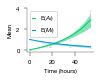

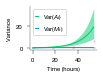

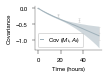

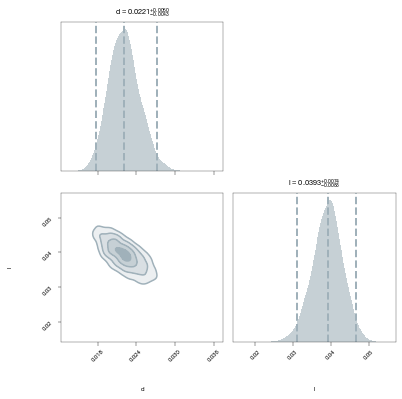

In [122]:
est = res[0]

# repair data set (due to newer memopy version)
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov $(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', settings=settings)

me.plots.est_corner_kernel_plot(est)

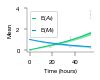

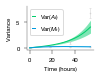

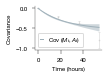

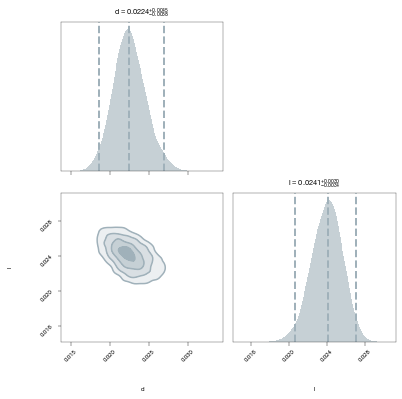

In [116]:
est = res[0]

# repair data set (due to newer memopy version)
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov $(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', settings=settings)

me.plots.est_corner_kernel_plot(est)

37


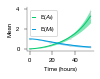

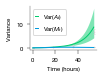

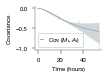

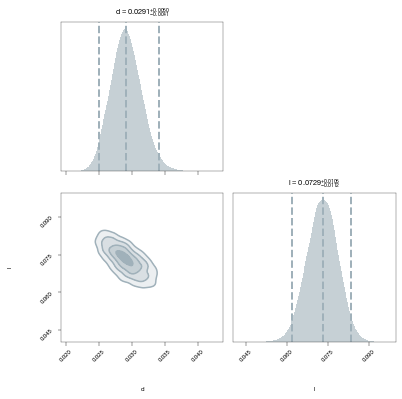

In [125]:
print(net_names.index('min_d_2_l_18')) # 37
est = res[37]

# repair data set (due to newer memopy version)
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', 
                               save='paper_figures/fit_cd44_mean_min_d_2_l_18_thin4_meanfit.pdf', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', 
                                   save='paper_figures/fit_cd44_var_min_d_2_l_18_thin4_meanfit.pdf', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov $(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', 
                                     save='paper_figures/fit_cd44_cov_min_d_2_l_18_thin4_meanfit.pdf', settings=settings)

me.plots.est_corner_kernel_plot(est, save='paper_figures/post_cd44_min_d_2_l_18_thin4_meanfit.pdf',)

39


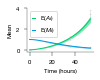

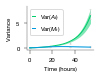

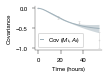

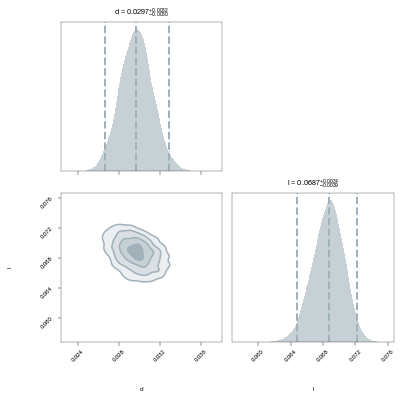

In [118]:
print(net_names.index('min_d_2_l_20')) # 39
est = res[39]

# repair data set (due to newer memopy version)
est.data.data_mean_exists_only = False

plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
settings = {
    'A_t': {'label': 'E$(A_t)$', 'color': cactiv},
    'M_t': {'label': 'E$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (hours)', settings=settings)

settings = {
    ('A_t', 'A_t'): {'label': 'Var$(A_t)$', 'color': cactiv},
    ('M_t', 'M_t'): {'label': 'Var$(M_t)$', 'color': cnaive}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (hours)', settings=settings)

settings = {
    ('A_t', 'M_t'): {'label': 'Cov $(M_t, A_t)$', 'color': grey}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (hours)', settings=settings)

me.plots.est_corner_kernel_plot(est)

##### Figure 5 <a id='figure5'></a> [↑](#top)

###### model topology

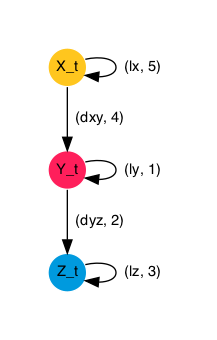

In [15]:
t = [
        {'start': 'X_t', 'end': 'Y_t', 'rate_symbol': 'dxy', 'type': 'S -> E', 'reaction_steps': 4},
        {'start': 'Y_t', 'end': 'Z_t', 'rate_symbol': 'dyz', 'type': 'S -> E', 'reaction_steps': 2},
        {'start': 'X_t', 'end': 'X_t', 'rate_symbol': 'lx', 'type': 'S -> S + S', 'reaction_steps': 5},
        {'start': 'Y_t', 'end': 'Y_t', 'rate_symbol': 'ly', 'type': 'S -> S + S', 'reaction_steps': 1},
        {'start': 'Z_t', 'end': 'Z_t', 'rate_symbol': 'lz', 'type': 'S -> S + S', 'reaction_steps': 3},
        ]

net = me.Network('net_true')
net.structure(t)

# need hex colors here
# "#FF1F5B", "#00CD6C", "#009ADE"
node_settings = {
    'X_t': {'label': 'X_t', 'color': "#FFC61E"},
    'Y_t': {'label': 'Y_t', 'color': "#FF1F5B"},
    'Z_t': {'label': 'Z_t', 'color': "#009ADE"},
}
me.plots.net_main_plot(net, node_settings=node_settings, save='paper_figures/topol_true_model.pdf')
# me.plots.net_hidden_plot(net, layout='dot')

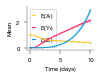

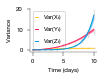

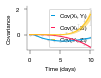

In [51]:
# data and fit of true model
res = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_surround.pickle', 'rb'))
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
data = res[0].data

est = res[0]
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})

settings = {
    'X_t': {'label': 'E$(X_t)$', 'color': ctopx},
    'Y_t': {'label': 'E$(Y_t)$', 'color': ctopy},
    'Z_t': {'label': 'E$(Z_t)$', 'color': ctopz},
}
me.plots.est_bestfit_mean_plot(est, x_label='Time (days)', data=True, conf=True, save='paper_figures/fit_topol_data_mean_net42513.pdf', settings=settings)

settings = {
    ('X_t', 'X_t'): {'label': 'Var$(X_t)$', 'color': ctopx},
    ('Y_t', 'Y_t'): {'label': 'Var$(Y_t)$', 'color': ctopy},
    ('Z_t', 'Z_t'): {'label': 'Var$(Z_t)$', 'color': ctopz}
}
me.plots.est_bestfit_variance_plot(est, x_label='Time (days)', data=True, conf=True, save='paper_figures/fit_topol_data_var_net42513.pdf', settings=settings)

settings = {
    ('X_t', 'Y_t'): {'label': 'Cov$(X_t, Y_t)$', 'color': ctopz},
    ('X_t', 'Z_t'): {'label': 'Cov$(X_t, Z_t)$', 'color': ctopy},
    ('Y_t', 'Z_t'): {'label': 'Cov$(Y_t, Z_t)$', 'color': ctopx}
}
me.plots.est_bestfit_covariance_plot(est, x_label='Time (days)', data=True, conf=True, save='paper_figures/fit_topol_data_cov_net42513.pdf', settings=settings)

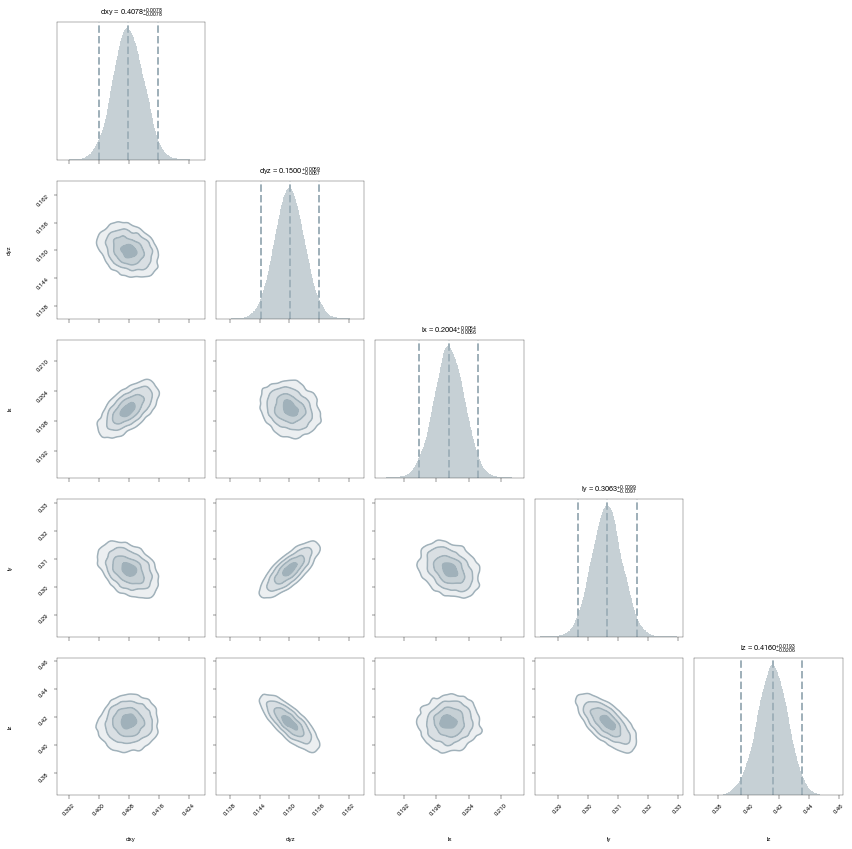

In [52]:
est = res[0]
me.plots.est_corner_kernel_plot(est, save='paper_figures/corner_net42513.pdf')

In [53]:
sns.color_palette('Set2', n_colors=3).as_hex()

['#66c2a5', '#fc8d62', '#8da0cb']

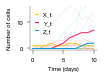

In [54]:
plt.rcParams.update({'figure.figsize': (1.2, 0.8)})
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

trace_emph = 4
for trace_i in range(10):
    if trace_i!=trace_emph:
        plt.plot(data.data_time_values, data.data_counts[trace_i, 0, :], color=ctopx, alpha=0.15, linewidth=0.5)
        plt.plot(data.data_time_values, data.data_counts[trace_i, 1, :], color=ctopy, alpha=0.15, linewidth=0.5)
        plt.plot(data.data_time_values, data.data_counts[trace_i, 2, :], color=ctopz, alpha=0.15, linewidth=0.5)
    else:
        plt.plot(data.data_time_values, data.data_counts[trace_i, 0, :], color=ctopx, alpha=1.0, linewidth=1.0, label='X_t', zorder=1000) # color='darkgreen'
        plt.plot(data.data_time_values, data.data_counts[trace_i, 1, :], color=ctopy, alpha=1.0, linewidth=1.0, label='Y_t', zorder=1000) # color='darkblue'
        plt.plot(data.data_time_values, data.data_counts[trace_i, 2, :], color=ctopz, alpha=1.0, linewidth=1.0, label='Z_t', zorder=1000) # color='darkblue'

# ax.set_ylim([-0.3, None])
leg = plt.legend()
plt.legend(frameon=False)
# leg.get_frame().set_edgecolor('lightgrey')
plt.ylim((-0.5, 16))
plt.xlabel('Time (days)')
plt.ylabel('Number of cells')
plt.savefig(f'paper_figures/data_topol_single_well_traces.pdf', bbox_inches='tight')

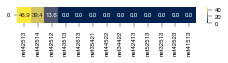

In [55]:
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

plt.figure(figsize=(4.0,0.3))
df = pd.DataFrame(np.array([model_probs_sorted]) * 100.0, columns=net_names_sorted) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/topol_top_models.pdf', bbox_inches='tight')

###### topology A (true) results

In [121]:
res_evids = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_toptrue3125_evids.pickle', 'rb'))
print(len(res_evids))

3125


In [122]:
net_names = [e[0] for e in res_evids]
log_evids = np.array([e[1] for e in res_evids])
model_probs = me.selection.compute_model_probabilities_from_log_evidences(log_evids)
print(net_names[list(model_probs).index(max(model_probs))])
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

net42513


In [123]:
print(model_probs_sorted[:10])
print(net_names_sorted[:10])

[4.01548985e-01 2.65501834e-01 1.81420908e-01 1.14624984e-01
 3.60233626e-02 8.68690121e-04 1.06347828e-05 4.87541599e-07
 5.78062316e-08 5.56034643e-08]
['net42513' 'net42514' 'net42515' 'net42512' 'net43511' 'net43512'
 'net43513' 'net43514' 'net42511' 'net43515']


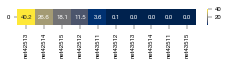

In [118]:
plt.figure(figsize=(4.0,0.3))
df = pd.DataFrame(np.array([model_probs_sorted[:10] * 100.0]), columns=net_names_sorted[:10]) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/topol_top_models_A.pdf', bbox_inches='tight')

###### topology B results

In [134]:
res_evids1 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topB3125_part1_evids.pickle', 'rb'))
res_evids2 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topB3125_part2_evids.pickle', 'rb'))
res_evids3 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topB3125_part3_evids.pickle', 'rb'))
res_evids = res_evids1 + res_evids2 + res_evids3
print(len(res_evids))

3125


In [135]:
net_names = [e[0] for e in res_evids]
log_evids = np.array([e[1] for e in res_evids])
model_probs = me.selection.compute_model_probabilities_from_log_evidences(log_evids)
print(net_names[list(model_probs).index(max(model_probs))])
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

net51212


In [136]:
print(model_probs_sorted[:10])
print(net_names_sorted[:10])

[1.00000000e+00 4.63105079e-11 1.60171055e-14 3.70226979e-19
 5.40904368e-21 2.57726313e-21 1.10924191e-30 6.61394015e-35
 2.11879657e-38 1.78506714e-42]
['net51212' 'net51213' 'net51222' 'net51232' 'net51242' 'net51252'
 'net51223' 'net51214' 'net51233' 'net51243']


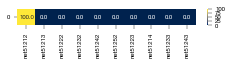

In [137]:
plt.figure(figsize=(4.0,0.3))
df = pd.DataFrame(np.array([model_probs_sorted[:10] * 100.0]), columns=net_names_sorted[:10]) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/topol_top_models_B.pdf', bbox_inches='tight')

In [138]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
data = res[0].data

###### topology C results

In [147]:
res_evids1 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topC3125_part1_evids.pickle', 'rb'))
res_evids2 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topC3125_part2_evids.pickle', 'rb'))
res_evids = res_evids1 + res_evids2
print(len(res_evids))

3125


In [148]:
net_names = [e[0] for e in res_evids]
log_evids = np.array([e[1] for e in res_evids])
model_probs = me.selection.compute_model_probabilities_from_log_evidences(log_evids)
print(net_names[list(model_probs).index(max(model_probs))])
sort_inds = np.array(- model_probs).argsort()
net_names_sorted = np.array(net_names)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

net35515


In [149]:
print(model_probs_sorted[:10])
print(net_names_sorted[:10])

[9.89435443e-01 1.04782609e-02 8.01854396e-05 3.66500769e-06
 2.44255197e-06 2.95692242e-09 5.02428379e-11 4.56107827e-13
 8.37346281e-14 1.24742827e-15]
['net35515' 'net35514' 'net35415' 'net35513' 'net35414' 'net35413'
 'net45515' 'net45514' 'net35512' 'net35412']


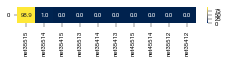

In [150]:
plt.figure(figsize=(4.0,0.3))
df = pd.DataFrame(np.array([model_probs_sorted[:10] * 100.0]), columns=net_names_sorted[:10]) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/topol_top_models_C.pdf', bbox_inches='tight')

###### summary

In [151]:
evidsA = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_toptrue3125_evids.pickle', 'rb'))
evidsB1 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topB3125_part1_evids.pickle', 'rb'))
evidsB2 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topB3125_part2_evids.pickle', 'rb'))
evidsB3 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topB3125_part3_evids.pickle', 'rb'))
evidsC1 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topC3125_part1_evids.pickle', 'rb')) 
evidsC2 = pickle.load(open('estimation_data_pathway_topology_n1000_t11_2_topC3125_part2_evids.pickle', 'rb'))

evidsB = evidsB1 + evidsB2 + evidsB3
evidsC = evidsC1 + evidsC2
print(len(evidsA), len(evidsB), len(evidsC))

logevidsall = np.array([e[1] for e in evidsA+evidsB+evidsC])
print(len(logevidsall))
namesall = np.array(['A' + e[0][3:] for e in evidsA] + ['B' + e[0][3:] for e in evidsB] + ['C' + e[0][3:] for e in evidsC])

3125 3125 3125
9375


In [152]:
model_probs = me.selection.compute_model_probabilities_from_log_evidences(logevidsall)
print(namesall[list(model_probs).index(max(model_probs))])
sort_inds = np.array(- model_probs).argsort()
namesall_sorted = np.array(namesall)[sort_inds]
model_probs_sorted = np.array(model_probs)[sort_inds]

A42513


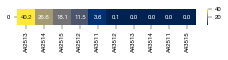

In [153]:
plt.figure(figsize=(4.0,0.3))
df = pd.DataFrame(np.array([model_probs_sorted[:10] * 100.0]), columns=namesall_sorted[:10]) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=90)
plt.savefig('paper_figures/topol_top_models_all.pdf', bbox_inches='tight')

0.9999999999999934 0.0 9.646173351363013e-220


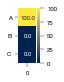

In [163]:
probssumA = np.sum(model_probs[:3125])
probssumB = np.sum(model_probs[3125:6250])
probssumC = np.sum(model_probs[6250:])
print(probssumA, probssumB, probssumC)

plt.figure(figsize=(0.4,1))
df = pd.DataFrame(np.array([probssumA, probssumB, probssumC]) * 100.0, index=['A', 'B', 'C']) # , index=rows
sns.heatmap(df, cmap='cividis', annot=True, fmt='.1f') # 'plasma' # annot=True
plt.yticks(rotation=0, va='center')
plt.savefig('paper_figures/topol_summary_probs.pdf', bbox_inches='tight')
plt.show()